In [128]:
#importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
#load data in dataframe
df = pd.read_excel("Data_Dictionary.xlsx")

In [320]:
df.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [131]:
# Read the CSV file with low_memory set to False
loandf = pd.read_csv("loan.csv", low_memory=False)

In [132]:
loandf.shape

(39717, 111)

In [133]:
loandf.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Data Cleaning

In [135]:
def get_nan_columns_sorted(df):
    # Count NaN values for each column
    nan_count = df.isnull().sum()
    # Filter columns where NaN count is greater than 0
    nan_columns_sorted = nan_count[nan_count > 0].sort_values(ascending=False)
    return nan_columns_sorted

In [136]:
get_nan_columns_sorted(loandf).head()

bc_open_to_buy          39717
acc_open_past_24mths    39717
bc_util                 39717
mo_sin_old_il_acct      39717
mo_sin_old_rev_tl_op    39717
dtype: int64

In [137]:
pd.set_option('display.max_rows', None)

In [138]:
# Drop columns where all values are NaN
loandf_cleaned = loandf.dropna(axis=1, how='all')

In [139]:
loandf_cleaned.shape

(39717, 57)

In [140]:
# Get columns where the number of unique values is 1
single_value_cols = loandf_cleaned.columns[loandf_cleaned.nunique() == 1].tolist()

In [141]:
single_value_cols

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [142]:
# Drop these columns from the DataFrame as these will not contribute to analysis
loandf_cleaned = loandf_cleaned.drop(columns=single_value_cols)

In [143]:
loandf_cleaned.shape

(39717, 48)

In [144]:
get_nan_columns_sorted(loandf_cleaned).head(2)

next_pymnt_d              38577
mths_since_last_record    36931
dtype: int64

In [145]:
loandf_cleaned[["next_pymnt_d","loan_status"]].head()

,next_pymnt_d,loan_status
0,NaN,Fully Paid
1,NaN,Charged Off
2,NaN,Fully Paid
3,NaN,Fully Paid
4,Jun-16,Current


In [146]:
# Leaving NaN as is for next_paymnt_d as it actually means "No Payment due", cocedering the loan_status column
# Find rows where next_pymnt_d is NaN and loan_status is 'Current'
missing_next_pymnt_rows = loandf_cleaned[(loandf_cleaned['next_pymnt_d'].isnull()) & (loandf_cleaned['loan_status'] == 'Current')]
missing_next_pymnt_rows.shape

(0, 48)

In [147]:
# Find rows where next_pymnt_d is not NaN and loan_status is not 'Current'
non_current_with_payment_due = loandf_cleaned[(loandf_cleaned['next_pymnt_d'].notnull()) & (loandf_cleaned['loan_status'] != 'Current')]
non_current_with_payment_due.shape

(0, 48)

In [148]:
# It is clear that next_pymnt_d is realted to loan_status. 
# Data value is only for loan_status = Current
# Hence it is safe to drop the column as the information is there in loan status column
loandf_cleaned = loandf_cleaned.drop(columns=["next_pymnt_d"])

In [149]:
get_nan_columns_sorted(loandf_cleaned).head(2)

mths_since_last_record    36931
mths_since_last_delinq    25682
dtype: int64

In [150]:
#handling mths_since_last_record fiield
loandf_cleaned[["mths_since_last_record","loan_status"]].head()

,mths_since_last_record,loan_status
0,NaN,Fully Paid
1,NaN,Charged Off
2,NaN,Fully Paid
3,NaN,Fully Paid
4,NaN,Current


In [151]:
loandf_cleaned.mths_since_last_record.info()

<class 'pandas.core.series.Series'>
RangeIndex: 39717 entries, 0 to 39716
Series name: mths_since_last_record
Non-Null Count  Dtype  
--------------  -----  
2786 non-null   float64
dtypes: float64(1)
memory usage: 310.4 KB


In [152]:
# Create a new column 'has_public_record' where 'mths_since_last_record' is NaN => 'No', else 'Yes'
loandf_cleaned.loc[:, 'has_public_record'] = np.where(loandf_cleaned['mths_since_last_record'].isnull(), 'No', 'Yes')

In [153]:
loandf_cleaned.has_public_record.value_counts()

has_public_record
No     36931
Yes     2786
Name: count, dtype: int64

In [154]:
# Dropping the mths_since_last_record column
loandf_cleaned = loandf_cleaned.drop(columns=["mths_since_last_record"])

In [155]:
#handling mths_since_last_delinq column
# mths_since_last_delinq has 64.6% null values. But NaN value maeans the accounts have never been delinquent
# Create a new column has_delinquency with Yes and No values
loandf_cleaned.loc[:,'has_delinquency'] = np.where(loandf_cleaned['mths_since_last_delinq'].isnull(), 'No', 'Yes')

In [156]:
loandf_cleaned.has_delinquency.value_counts()

has_delinquency
No     25682
Yes    14035
Name: count, dtype: int64

In [157]:
# Dropping the mths_since_last_record column
loandf_cleaned = loandf_cleaned.drop(columns=["mths_since_last_delinq"])

In [158]:
loandf_cleaned.desc.head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [159]:
#handling desc column. It is difficult to make any sense of text at this point.
#create a new column has_desc
loandf_cleaned.loc[:,'has_desc'] = np.where(loandf_cleaned['desc'].isnull(), 'No', 'Yes')

In [160]:
loandf_cleaned.has_desc.value_counts()

has_desc
Yes    26775
No     12942
Name: count, dtype: int64

In [161]:
#dropping desc column
loandf_cleaned = loandf_cleaned.drop(columns=['desc'])

In [162]:
#loandf_cleaned.emp_title.head()
print(get_nan_columns_sorted(loandf_cleaned).head(2))
loandf_cleaned.emp_title.nunique()

emp_title     2459
emp_length    1075
dtype: int64


28820

In [163]:
# handling emp_title column
# about 6% is null. This can be either rhe borrower was unemployed or simply did not provide details
# However this column is too diverse and has 28820 unique values, hence dropping the column
loandf_cleaned = loandf_cleaned.drop(columns=['emp_title'])

In [164]:
#handle emp_length
# this indicates job stability. Missing values may indicate borrower being unemployed or simple not provided.
# hence replacing nulls with Unknown seems a good approach
loandf_cleaned.loc[:,'emp_length'] = loandf_cleaned['emp_length'].fillna('Unknown')

In [165]:
loandf_cleaned.emp_length.value_counts()

emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Unknown      1075
Name: count, dtype: int64

In [166]:
loandf_cleaned.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.0    37339
1.0     1674
2.0        7
Name: count, dtype: int64

In [167]:
# Handling pub_rec_bankruptcies
# This column has 1.75 missing values
# It is very likely that missing values is because the borrowers have no bankrupcies as any bankrupcies is likely to be discovered by loan provider
# Hence fillling with 0.0 (which is also median) seems a reasonable approach here
loandf_cleaned.loc[:, 'pub_rec_bankruptcies'] = loandf_cleaned['pub_rec_bankruptcies'].fillna(0.0)

In [168]:
loandf_cleaned.pub_rec_bankruptcies.value_counts()

pub_rec_bankruptcies
0.0    38036
1.0     1674
2.0        7
Name: count, dtype: int64

In [169]:
# Handling last_pymnt_d
# Relative small .18% is missing
# No clear reason can be attributed
# In order to avoid any bias, dropping the rows seems reasonable
loandf_cleaned = loandf_cleaned.dropna(subset=['last_pymnt_d'])

In [170]:
loandf_cleaned.shape

(39646, 46)

In [171]:
loandf_cleaned.revol_util.value_counts().head()

revol_util
0%        975
0.20%      62
63%        62
0.10%      58
40.70%     58
Name: count, dtype: int64

In [172]:
# Handling revol_util
# Relativelly low .13 % null values
# As there is not clear memaning of null values, it seems best to drop the rows with null values
loandf_cleaned = loandf_cleaned.dropna(subset=['revol_util'])

In [173]:
# Remove '%' and convert 'revol_util' to float
loandf_cleaned.loc[:, 'revol_util'] = loandf_cleaned['revol_util'].str.rstrip('%').astype('float') / 100

In [174]:
loandf_cleaned.shape

(39600, 46)

In [175]:
print(get_nan_columns_sorted(loandf_cleaned).head(2))
loandf_cleaned.title.nunique()

title                 11
last_credit_pull_d     2
dtype: int64


19556

In [176]:
# Handling title
# title has only 11 null values
# since this column is also too diversem, hence dropping this column
loandf_cleaned = loandf_cleaned.drop(columns=['title'])

In [281]:
# handling zip_code
# This columns is also too diverse to analyses. Also we have state in the datadrame
loandf_cleaned =  loandf_cleaned.drop(columns=["zip_code"])

In [177]:
# Handling last_credit_pull_d
# Since there are only 2 null values, it is safe to drop there rows without any impact on EDA
# however this column is not expected to impact target valrable, hence dropping this column
loandf_cleaned = loandf_cleaned.drop(columns=['last_credit_pull_d'])

In [178]:
#Handling earliest_cr_line
# Convert 'earliest_cr_line' to datetime format
from datetime import datetime
loandf_cleaned['earliest_cr_line'] = pd.to_datetime(loandf_cleaned['earliest_cr_line'], format='%b-%y')

# Calculate the difference in years (credit age)
current_date = datetime.now()
loandf_cleaned['credit_line_age'] = (current_date - loandf_cleaned['earliest_cr_line']).dt.days // 365

# Drop the original 'earliest_cr_line' if needed
loandf_cleaned = loandf_cleaned.drop(columns=['earliest_cr_line'])
# Now 'credit_line_age' is a numerical feature representing the borrower's credit history length.

In [179]:
loandf_cleaned['credit_line_age'].value_counts()

credit_line_age
 24    3245
 25    3074
 26    2755
 23    2704
 27    2369
 28    2241
 29    2071
 22    1988
 30    1949
 21    1826
 20    1813
 19    1538
 31    1377
 18    1235
 32    1017
 33    1002
 34     993
 35     830
 17     794
 36     724
 37     573
 38     494
 39     468
 40     360
 41     332
 16     230
 42     213
 43     187
 44     178
 45     169
 46     167
 47     112
 48      89
 49      83
 50      68
 51      61
 54      50
 53      50
 52      48
 55      31
-44      20
-43      20
-40      10
-39      10
-42       8
-41       7
-38       6
-45       3
 15       2
-35       1
-32       1
-22       1
-27       1
-30       1
-31       1
Name: count, dtype: int64

In [180]:
#-ve values is due to incorrect century. To fix this we can add 76 to rows with -ve values
loandf_cleaned['credit_line_age'] = loandf_cleaned['credit_line_age'].apply(lambda x: x + 76 if x < 0 else x)

In [181]:
#handling last_pymnt_d. This column is not expected to contribute to analysis, hence can be dropped
loandf_cleaned = loandf_cleaned.drop(columns=["last_pymnt_d"])

In [235]:
# Handling issue_d": It will be intresting to see trend on issue_month, instead of issue date
# Step 1: Convert 'issue_d' to datetime format
loandf_cleaned['issue_d'] = pd.to_datetime(loandf_cleaned['issue_d'], format='%b-%y')

# Step 2: Extract month and create a new column (optional)
loandf_cleaned['issue_month'] = loandf_cleaned['issue_d'].dt.month  # Month as an integer (1-12)
loandf_cleaned['issue_year'] = loandf_cleaned['issue_d'].dt.year  
# Step 3: Drop the original 'issue_d' column
loandf_cleaned = loandf_cleaned.drop(columns=['issue_d'])

In [237]:
# url = https://lendingclub.com/browse/loanDetail.action?loan_id=1077501 is also does not seem to have any contribution to EDA
loandf_cleaned = loandf_cleaned.drop(columns=["url"])
#dropping id and member_id colums as there will not be analysed
loandf_cleaned = loandf_cleaned.drop(columns=["id", "member_id"])

In [239]:
loandf_cleaned.shape

(39600, 41)

In [241]:
# Clean the 'int_rate' column
loandf_cleaned.loc[:, 'int_rate'] = loandf_cleaned['int_rate'].str.rstrip('%').astype('float') / 100

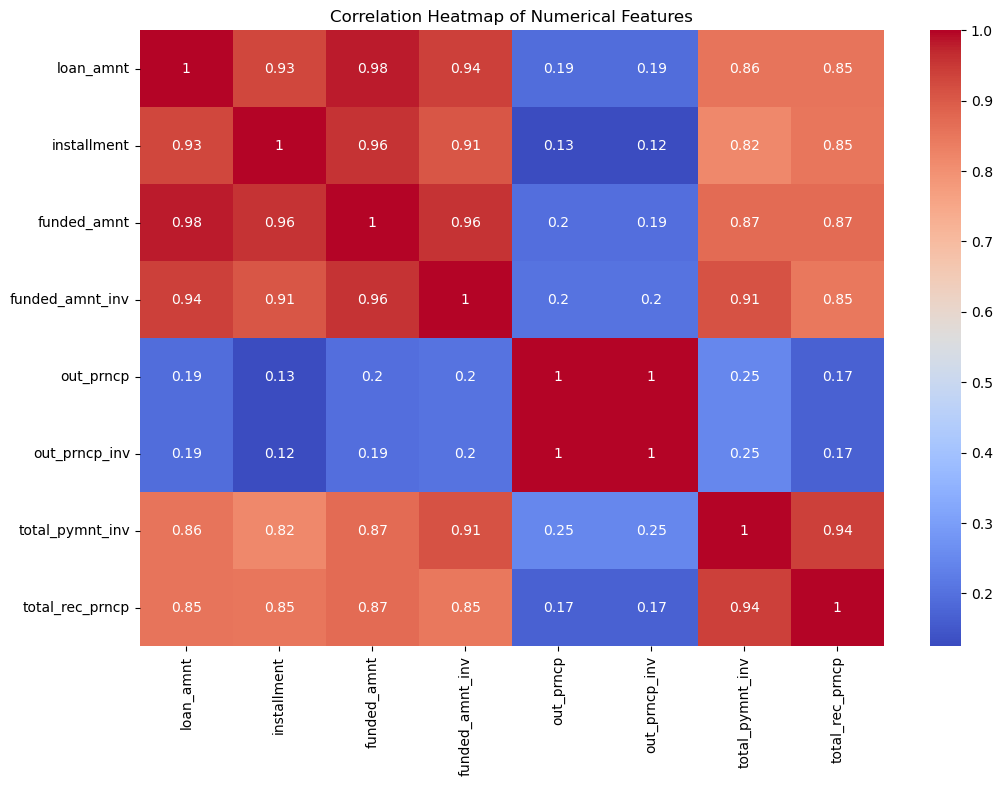

In [243]:
#Finding highly co related columns
corelated_cols = ["loan_amnt","installment","funded_amnt", "funded_amnt_inv", "out_prncp", "out_prncp_inv", "total_pymnt_inv", "total_rec_prncp"]
corr = loandf_cleaned[corelated_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [245]:
#loan_amnt: drop funded_amnt, funded_amnt_inv
# out_pnrcp: drop out_prncp_inv
# total_pymnt: drop total_pymnt_inv, total_rec_prncp
cols_to_remove = ["installment","funded_amnt", "funded_amnt_inv", "out_prncp_inv", "total_pymnt_inv"]

# Using list comprehension to filter out the columns
loandf_cleaned = loandf_cleaned.drop(columns=cols_to_remove)

In [247]:
def calculate_thresholds(col):
    return {
        'Very Low': col.quantile(0.25),   # 25th percentile
        'Low': col.quantile(0.50),        # 50th percentile (median)
        'Medium': col.quantile(0.75),     # 75th percentile
        'High': col.quantile(0.95)        # 95th percentile
    }


# Function to categorize based on the thresholds
def categorize(value, thresholds):
    if value <= thresholds['Very Low']:
        return 'Very Low'
    elif value <= thresholds['Low']:
        return 'Low'
    elif value <= thresholds['Medium']:
        return 'Medium'
    elif value <= thresholds['High']:
        return 'High'
    else:
        return 'Very High'

In [249]:
# Apply the function to categorize the annual income
thresholds = calculate_thresholds(loandf_cleaned['annual_inc'])
loandf_cleaned['income_category'] = loandf_cleaned['annual_inc'].apply(lambda x: categorize(x, thresholds))
loandf_cleaned = loandf_cleaned.drop(columns=["annual_inc"])

In [251]:
# Categorise revol_bal in similar way
loandf_cleaned['revol_bal'].describe()

count     39600.000000
mean      13408.853005
std       15894.529558
min           0.000000
25%        3722.750000
50%        8868.000000
75%       17085.250000
max      149588.000000
Name: revol_bal, dtype: float64

In [253]:
thresholds = calculate_thresholds(loandf_cleaned['revol_bal'])
loandf_cleaned['revol_bal_category'] = loandf_cleaned['revol_bal'].apply(lambda x: categorize(x, thresholds))
loandf_cleaned = loandf_cleaned.drop(columns=["revol_bal"])

In [255]:
loandf_cleaned['out_prncp'].describe()

count    39600.000000
mean        51.379242
std        375.716328
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6311.470000
Name: out_prncp, dtype: float64

In [257]:
# Log-transform the out_prncp column, adding 1 to avoid log(0)
loandf_cleaned['log_out_prncp'] = np.log1p(loandf_cleaned['out_prncp'])
loandf_cleaned = loandf_cleaned.drop(columns=["out_prncp"])

In [259]:
loandf_cleaned["total_pymnt"].describe()

count    39600.000000
mean     12182.849214
std       9037.478942
min         33.730000
25%       5597.812391
50%       9938.472576
75%      16565.400122
max      58563.679930
Name: total_pymnt, dtype: float64

In [261]:
# Log-transform the total_pymnt column
loandf_cleaned['log_total_pymnt'] = np.log1p(loandf_cleaned['total_pymnt'])
loandf_cleaned = loandf_cleaned.drop(columns=["total_pymnt"])
loandf_cleaned["log_total_pymnt"].describe()

count    39600.000000
mean         9.109194
std          0.845613
min          3.547604
25%          8.630310
50%          9.204269
75%          9.715132
max         10.977887
Name: log_total_pymnt, dtype: float64

In [263]:
# Log-transform the total_pymnt column
loandf_cleaned['log_total_rec_int'] = np.log1p(loandf_cleaned['total_rec_int'])
loandf_cleaned = loandf_cleaned.drop(columns=["total_rec_int"])
loandf_cleaned["log_total_rec_int"].describe()

count    39600.000000
mean         7.179024
std          1.118666
min          1.976855
25%          6.502711
50%          7.211328
75%          7.952108
max         10.067504
Name: log_total_rec_int, dtype: float64

In [265]:
# Log-transform the total_pymnt column
loandf_cleaned['log_last_pymnt_amnt'] = np.log1p(loandf_cleaned['last_pymnt_amnt'])
loandf_cleaned = loandf_cleaned.drop(columns=["last_pymnt_amnt"])
loandf_cleaned["log_last_pymnt_amnt"].describe()

count    39600.000000
mean         6.605212
std          1.759569
min          0.000000
25%          5.398344
50%          6.309809
75%          8.105326
max         10.494497
Name: log_last_pymnt_amnt, dtype: float64

In [267]:
bins = {
    "log_out_prncp": 50,
    "log_total_pymnt": 50,
    "log_total_rec_int": 50,
    "log_last_pymnt_amnt": 50
}

In [324]:
loandf_cleaned.shape

(39600, 35)

In [283]:
num_cols = []
cat_cols = []
extra_cols = []

# Loop through each column and classify based on unique values
for col in loandf_cleaned.columns:
    unique_values = loandf_cleaned[col].nunique()  # Get number of unique values in the column
    
    if unique_values > 20:
        num_cols.append(col)  # If more than 20 unique values, treat as numeric
    else:
        cat_cols.append(col)  # If 20 or fewer unique values, treat as categorical

In [285]:
print(num_cols, "\n\n" ,cat_cols)

['loan_amnt', 'int_rate', 'sub_grade', 'addr_state', 'dti', 'open_acc', 'revol_util', 'total_acc', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'credit_line_age', 'log_out_prncp', 'log_total_pymnt', 'log_total_rec_int', 'log_last_pymnt_amnt'] 

 ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies', 'has_public_record', 'has_delinquency', 'has_desc', 'issue_month', 'issue_year', 'income_category', 'revol_bal_category']


In [273]:
loandf_cleaned.iloc[:,0:40].head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,...,has_desc,credit_line_age,issue_month,issue_year,income_category,revol_bal_category,log_out_prncp,log_total_pymnt,log_total_rec_int,log_last_pymnt_amnt
0,5000,36 months,0.1065,B,B2,10+ years,RENT,Verified,Fully Paid,credit_card,...,Yes,39,12,2011,Very Low,Medium,0.000000,8.676614,6.761758,5.151093
1,2500,60 months,0.1527,C,C4,< 1 year,RENT,Source Verified,Charged Off,car,...,Yes,25,12,2011,Very Low,Very Low,0.000000,6.917418,6.078032,4.792977
2,2400,36 months,0.1596,C,C5,10+ years,RENT,Not Verified,Fully Paid,small_business,...,No,22,12,2011,Very Low,Very Low,0.000000,8.008587,6.407985,6.478371
3,10000,36 months,0.1349,C,C1,10+ years,RENT,Source Verified,Fully Paid,other,...,Yes,28,12,2011,Low,Low,0.000000,9.411884,7.703423,5.881873
4,3000,60 months,0.1269,B,B5,1 year,RENT,Source Verified,Current,other,...,Yes,28,12,2011,Medium,High,6.263513,8.164604,6.945427,4.231058


In [287]:
# sub_grade is categorical column
cat_cols_observed = ["sub_grade", "addr_state"];
num_cols_observed = ["delinq_2yrs", "inq_last_6mths", "pub_rec", "pub_rec_bankruptcies"]
# Remove columns from num_cols that are present in cat_cols_observed
num_cols = [col for col in num_cols if col not in cat_cols_observed]
cat_cols = [col for col in cat_cols if col not in num_cols_observed]
# Append the columns from cat_cols_observed to cat_cols
cat_cols = cat_cols + cat_cols_observed
num_cols = num_cols + num_cols_observed

In [326]:
print(loandf_cleaned.shape, len(num_cols + cat_cols))

(39600, 35) 35


### Univariate Analysis

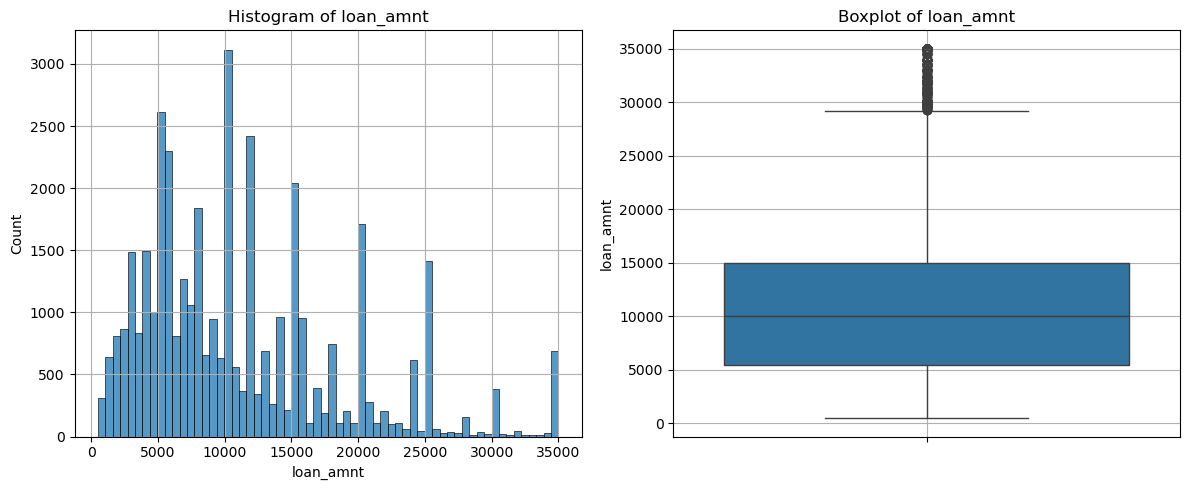

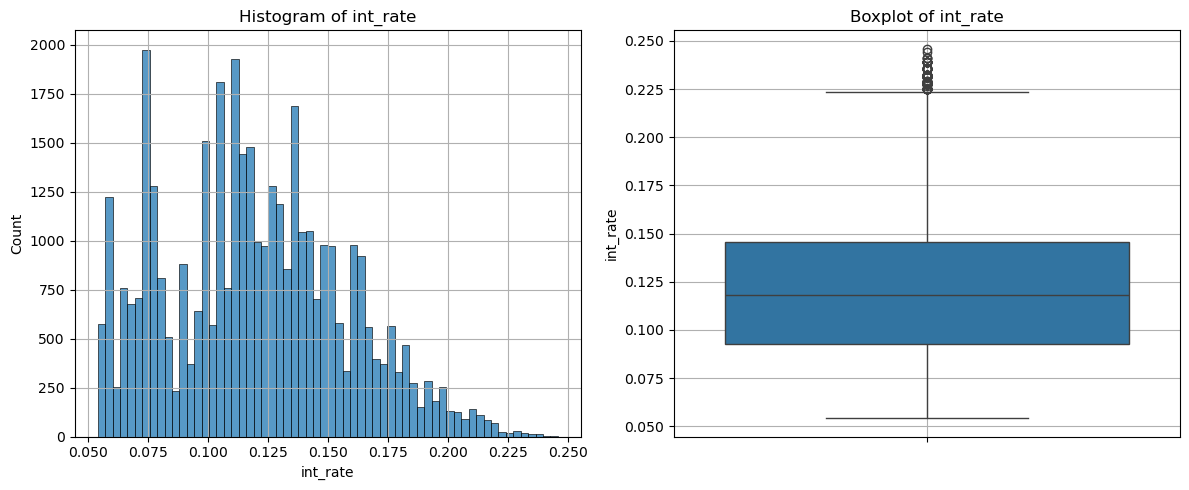

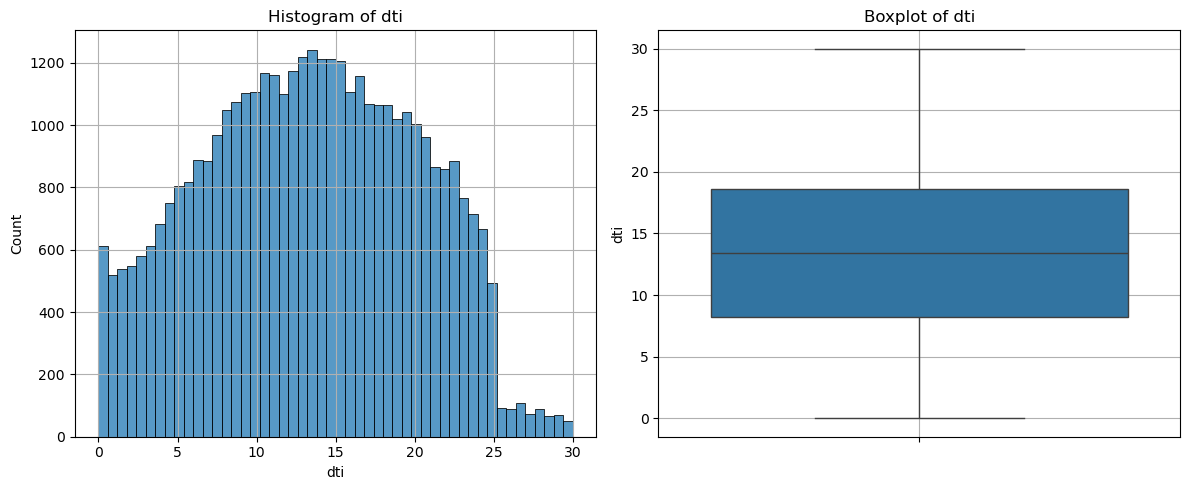

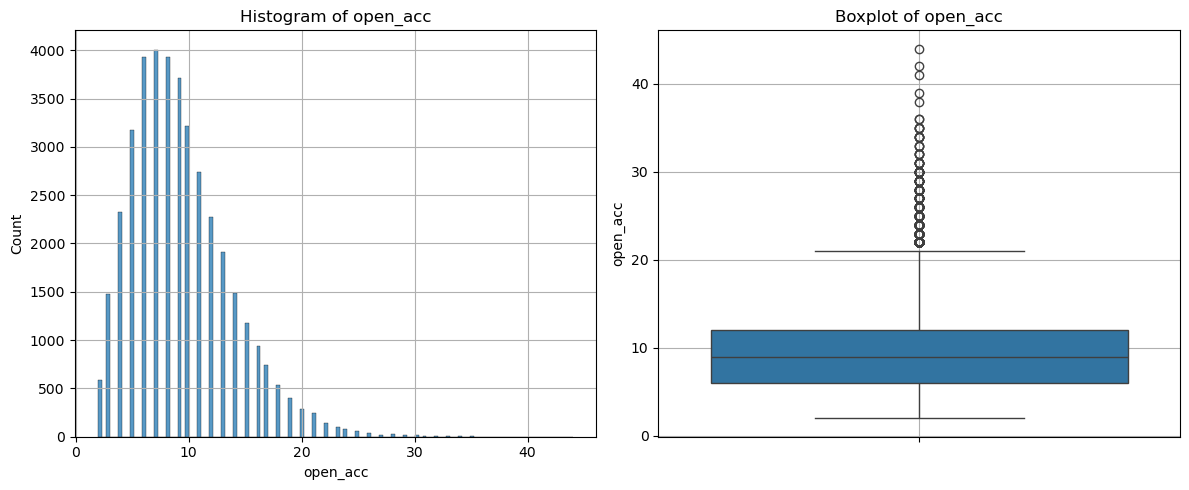

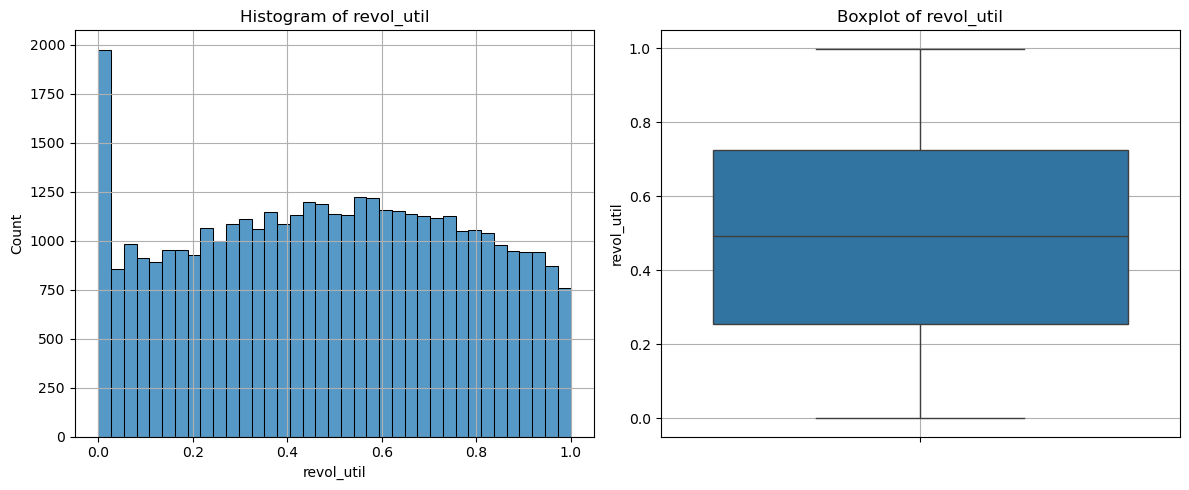

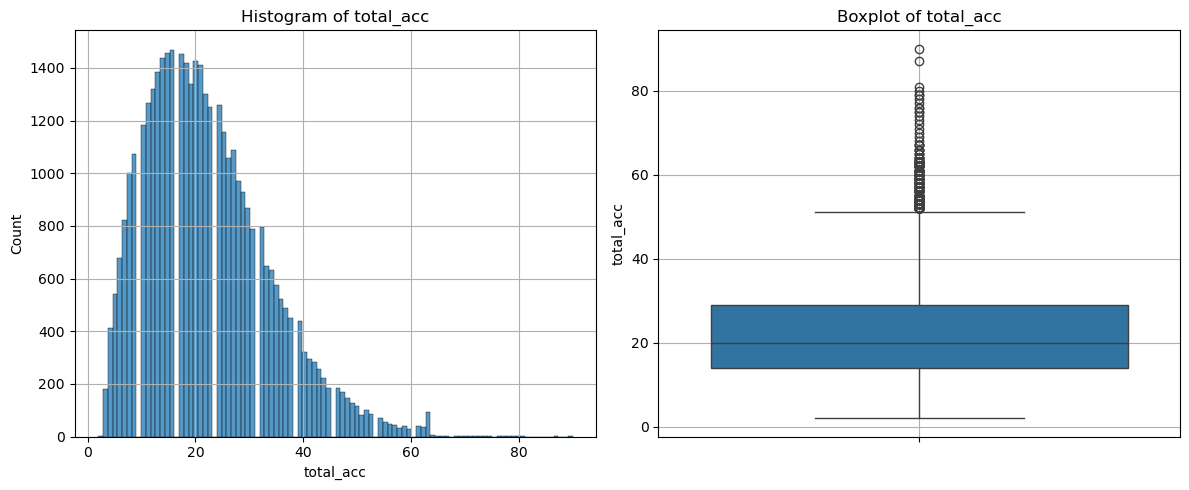

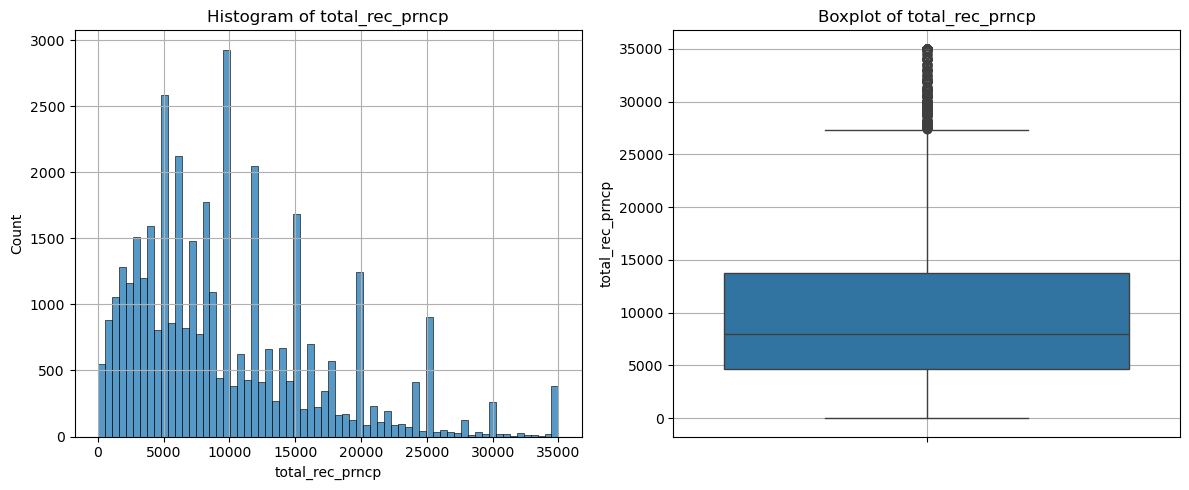

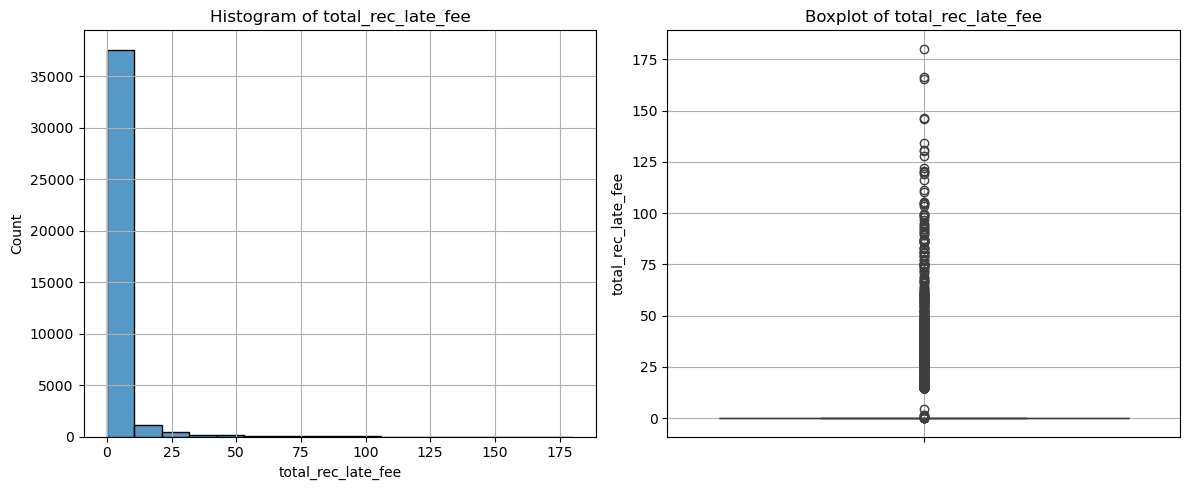

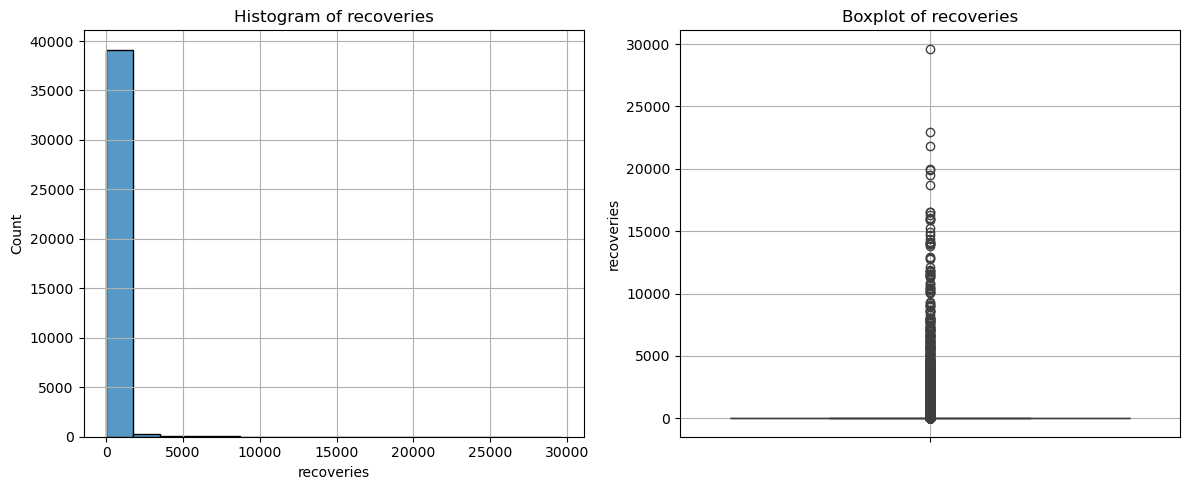

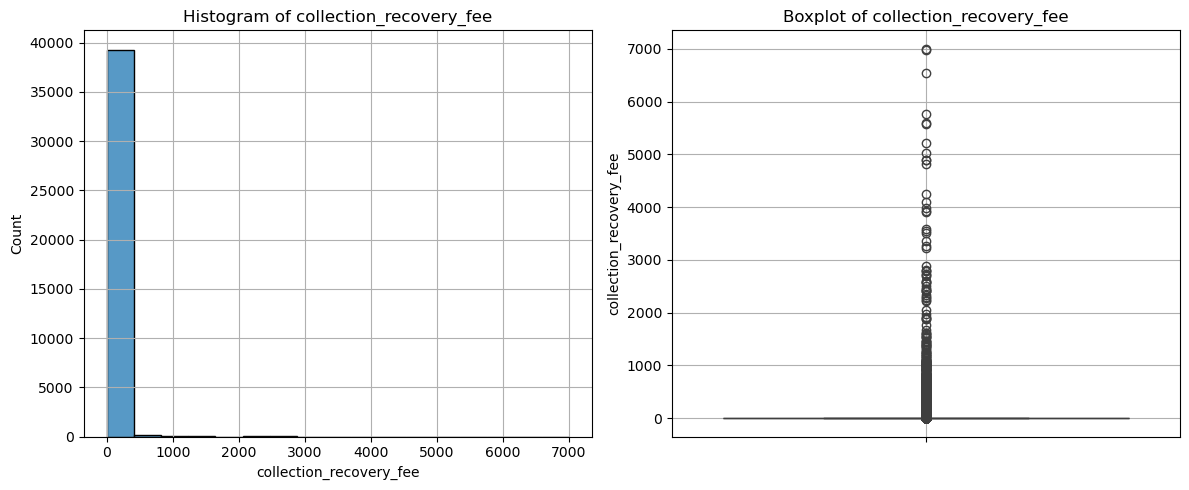

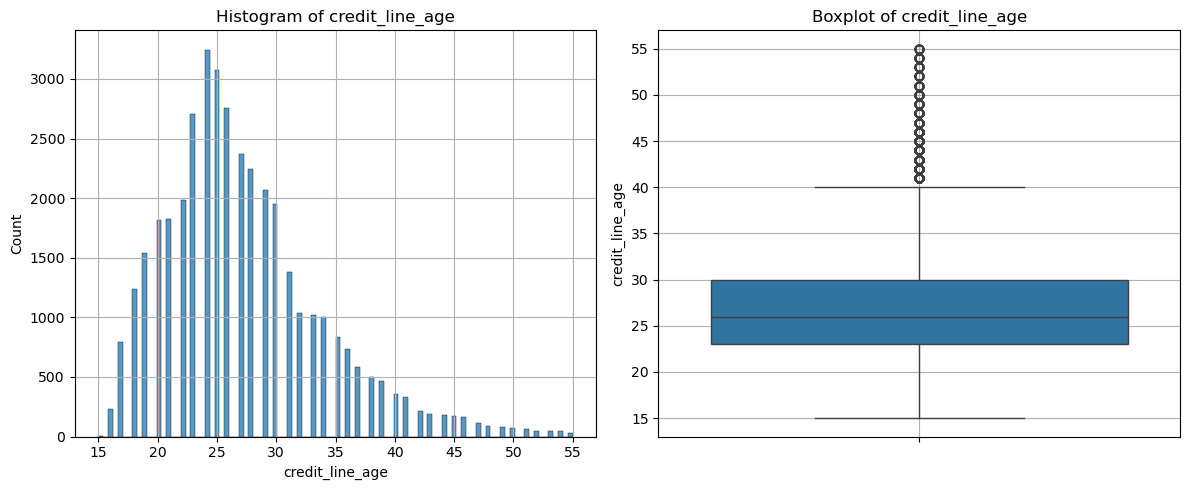

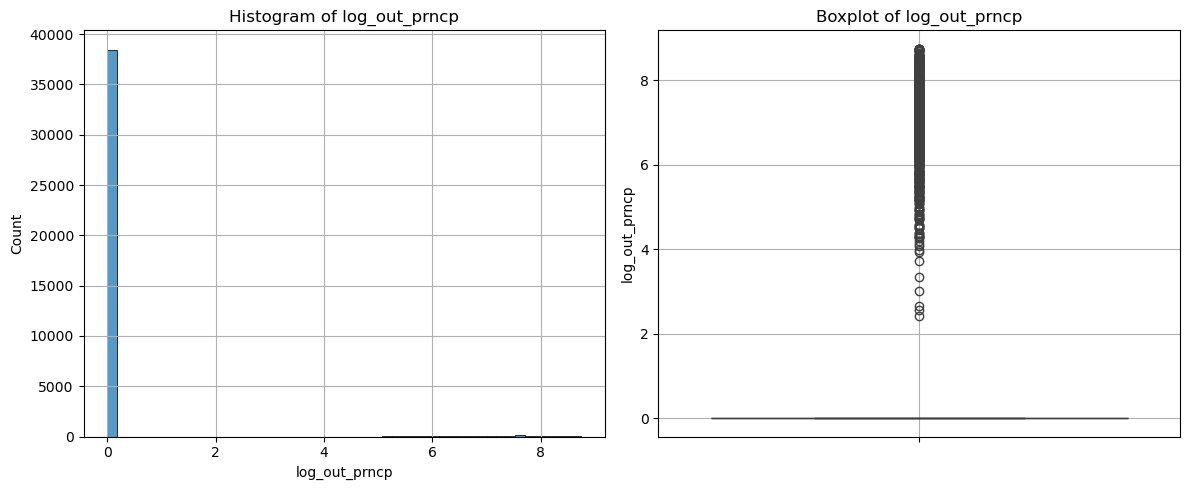

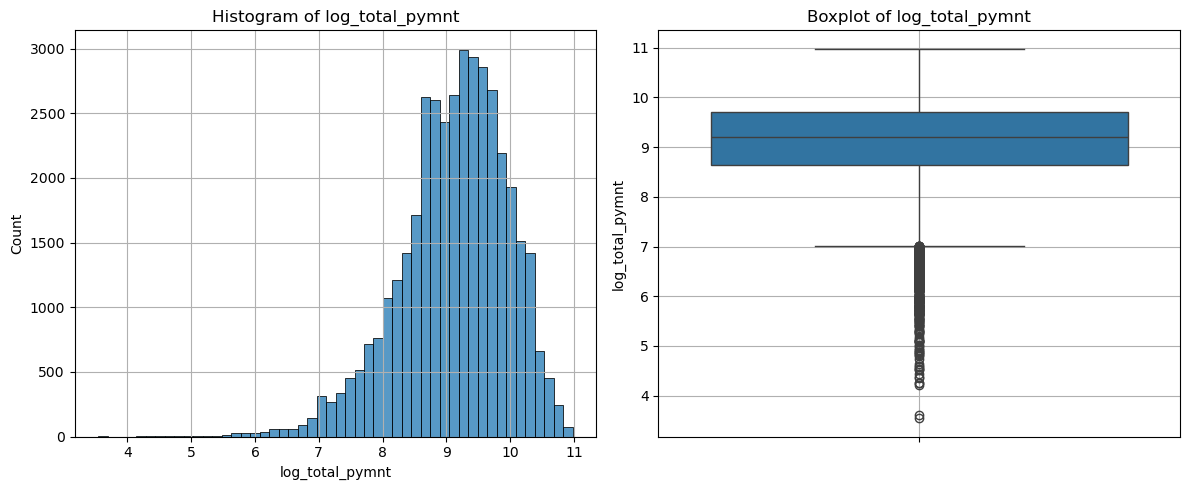

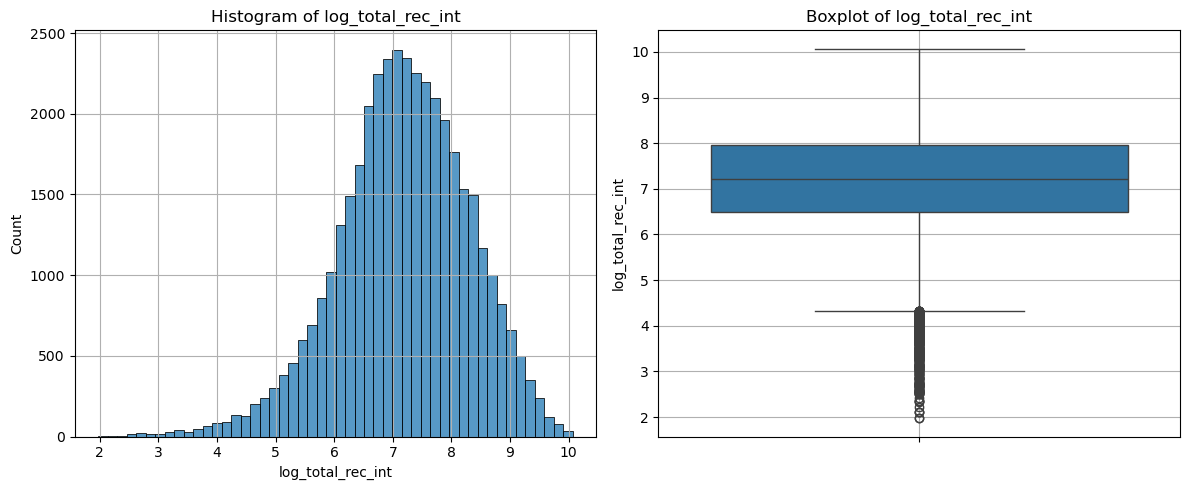

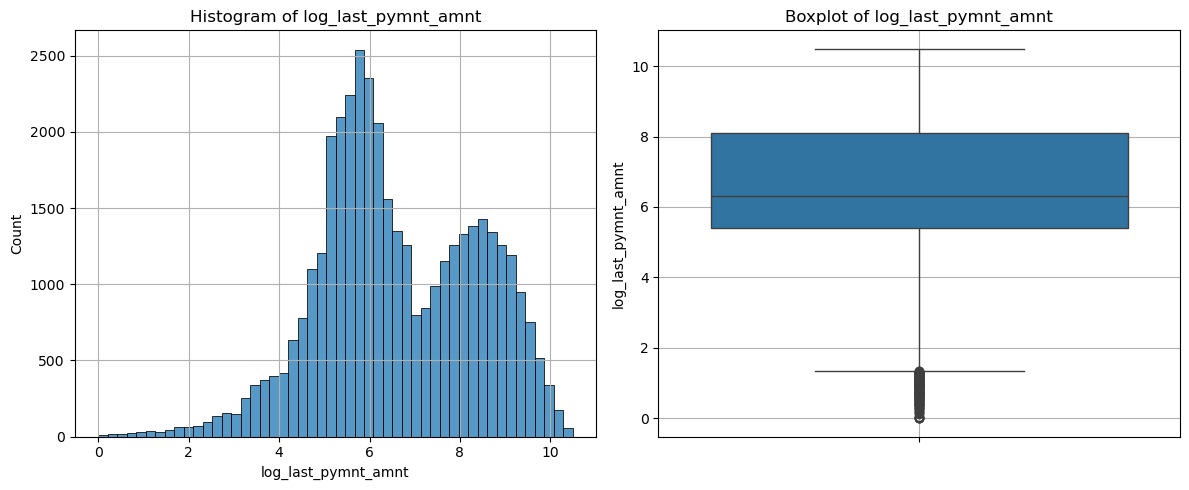

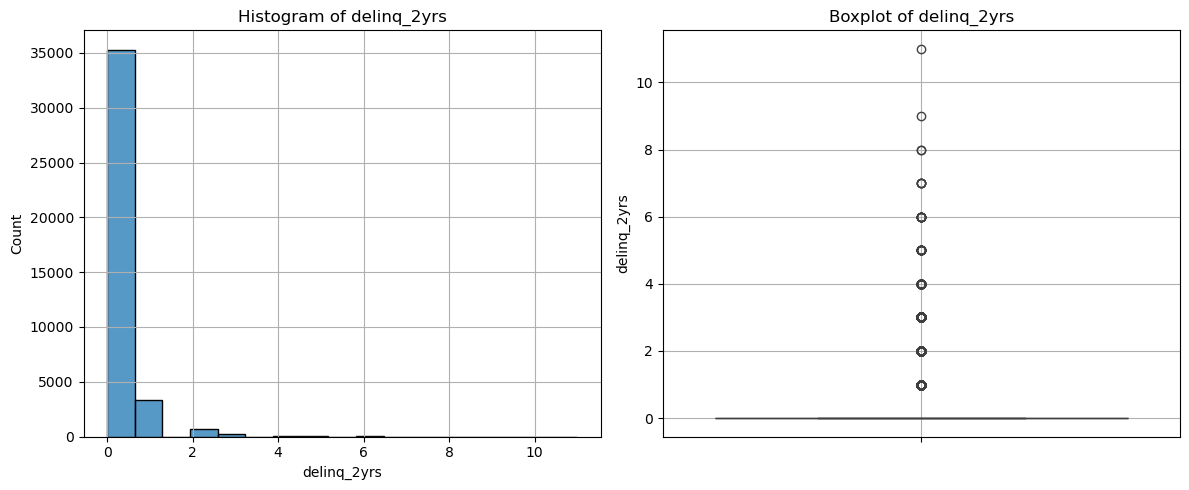

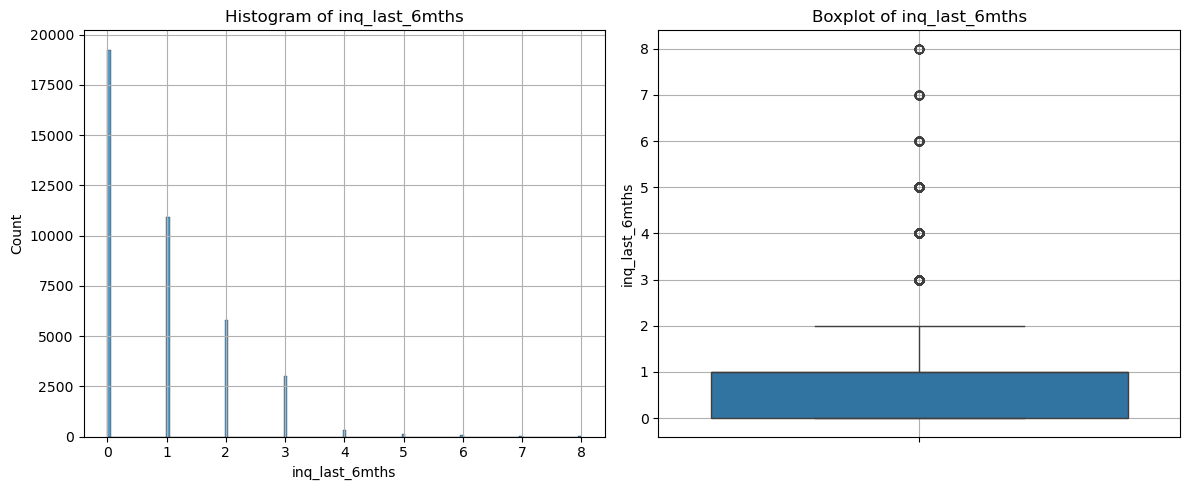

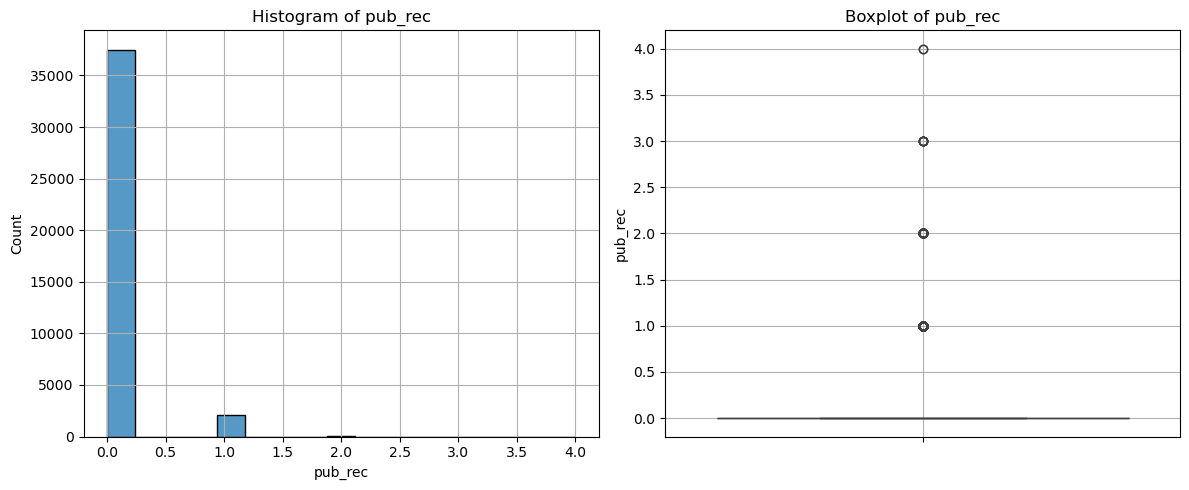

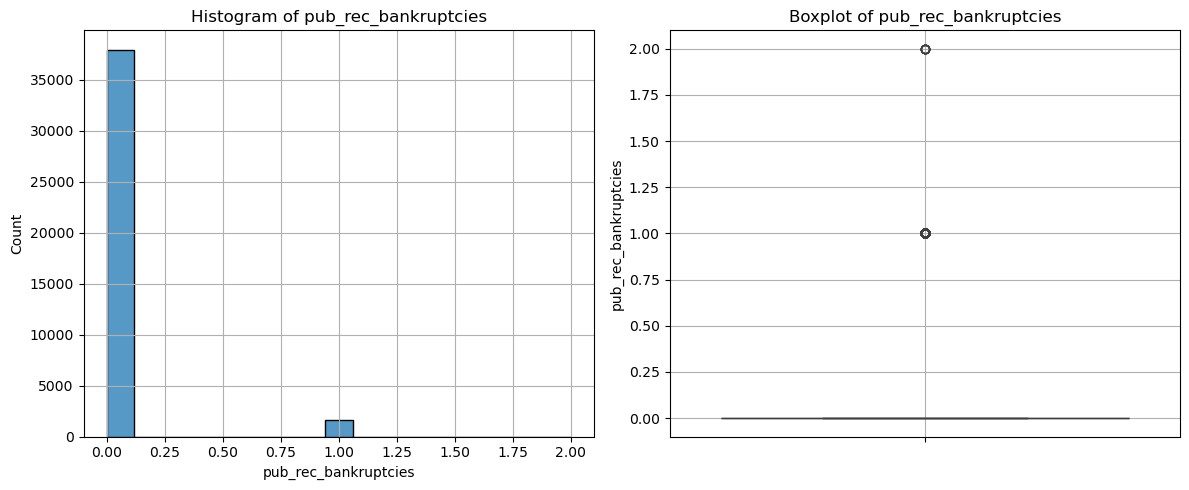

In [305]:
for col in num_cols:
        # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Plot histogram on the first subplot
    if col in bins:
        sns.histplot(x=loandf_cleaned[col], bins=bins[col], ax=axes[0])
    else:
        sns.histplot(x=loandf_cleaned[col], ax=axes[0])
        
    axes[0].set_title(f'Histogram of {col}')
    axes[0].set_xlabel(col)
    axes[0].grid(True)  # Add grid

    # Plot boxplot on the second subplot
    sns.boxplot(y=loandf_cleaned[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    axes[1].set_ylabel(col)
    axes[1].grid(True)  # Add grid
    
    # Show the combined plots
    plt.tight_layout()  # Adjusts the spacing between plots
    plt.show()

#### loan_amt: 
##### plot is right skewed, also there are outliars on the highr side: This means most of the loans are of lower value. 
##### However there are few very high value loans. This certainly indicates increased risk


#### int_rate, installment
##### is also right skewed and outliars on top.

#### annual_income - is log transformed due to the high range. Seems to be normally distributed. but has outliars both below and above.

#### dti:
##### Has normal distribution with no outliars

#### open_acct:
##### Has rightskewed distribution with outliars at top

#### revol_bal
##### After log transform, is left skewed and has outliars on the bottom

### Segment Univariate Analysis

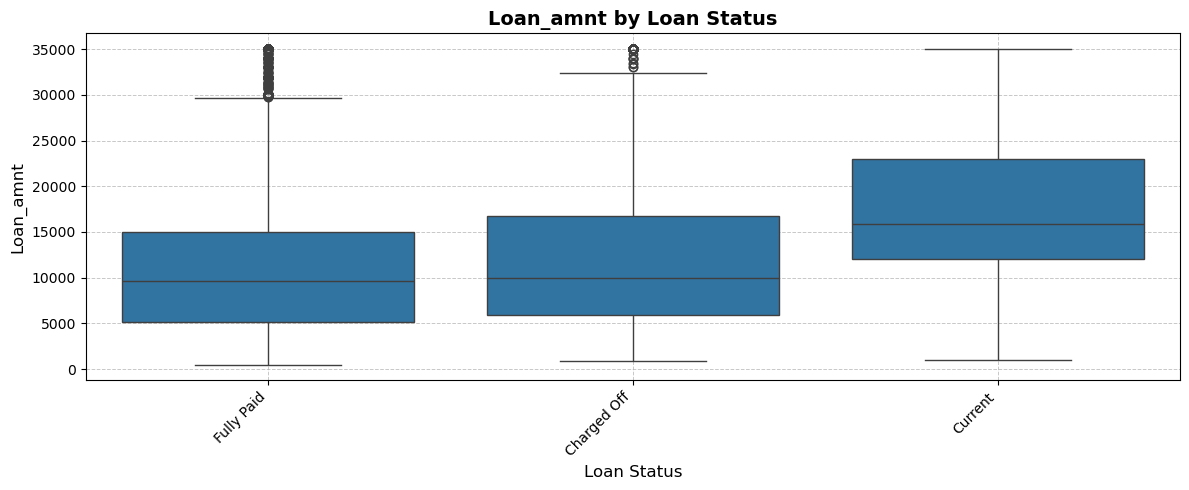

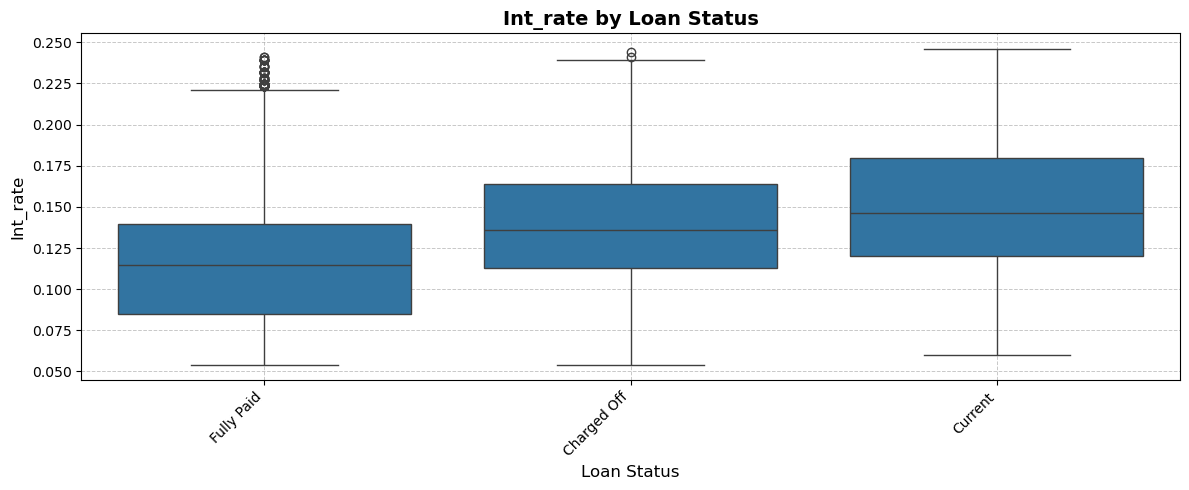

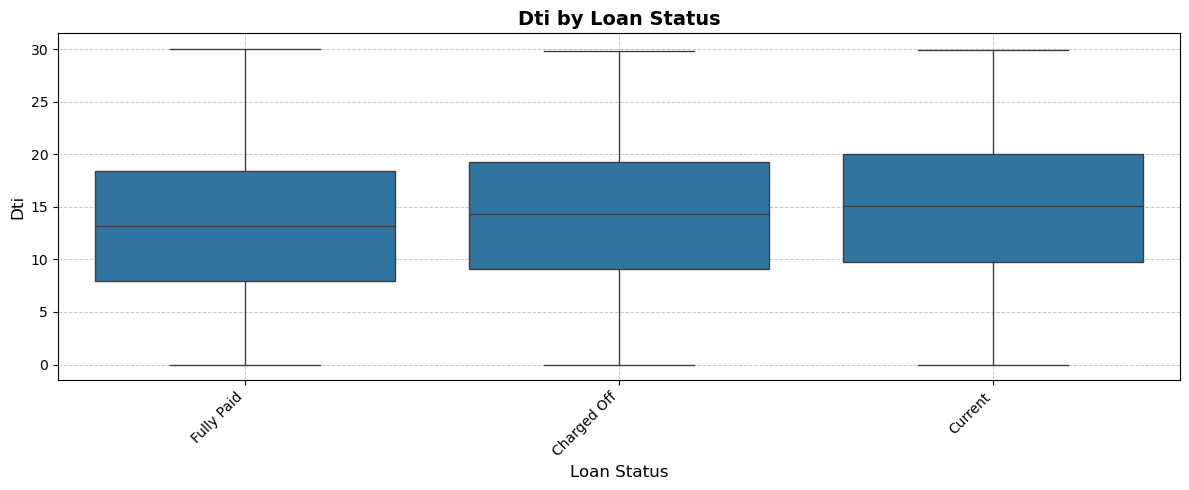

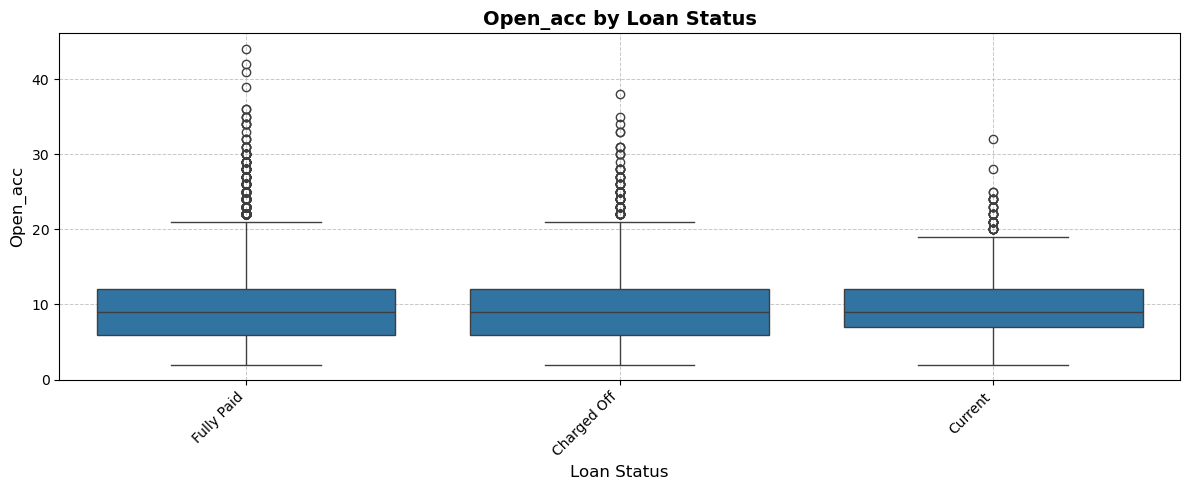

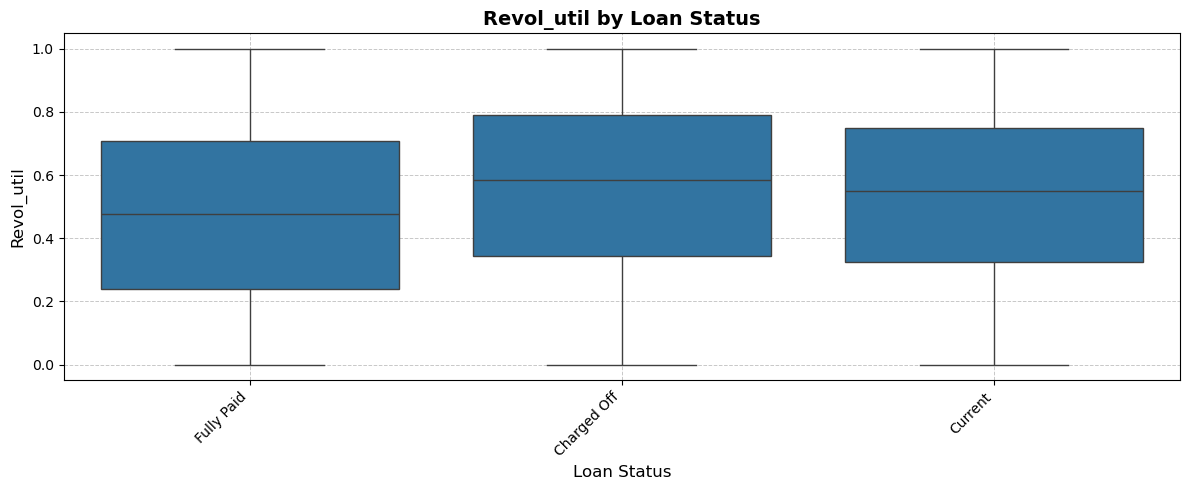

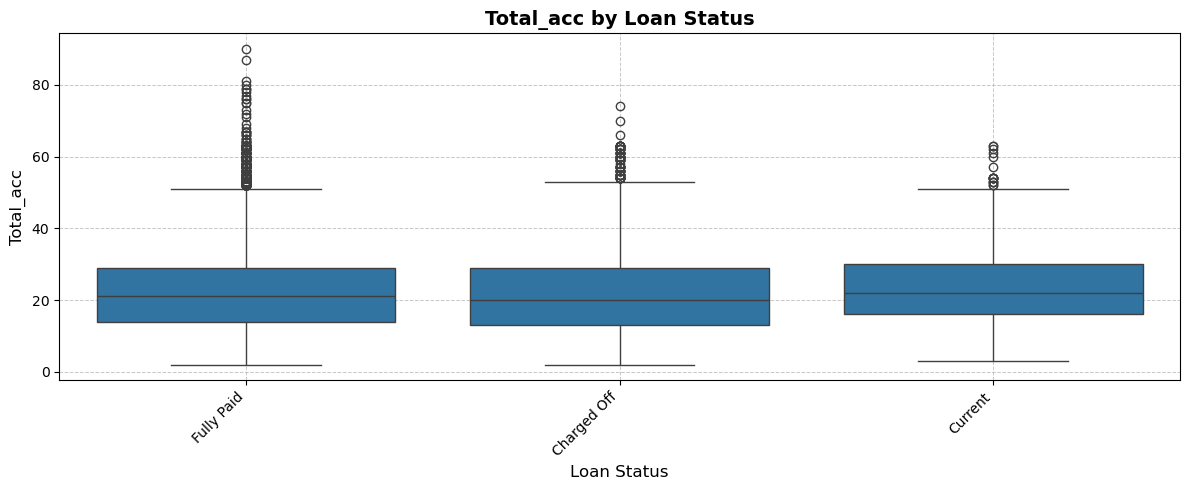

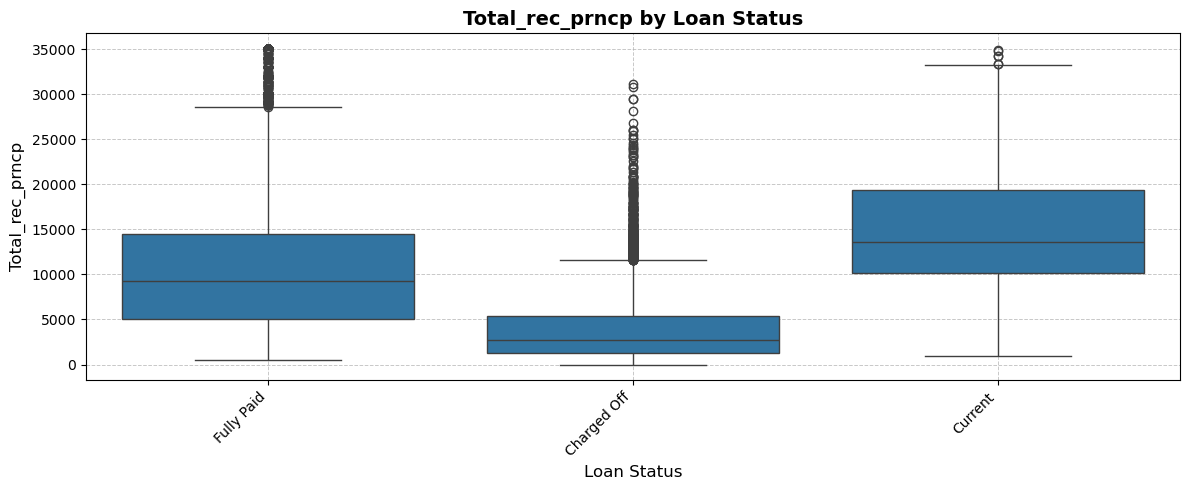

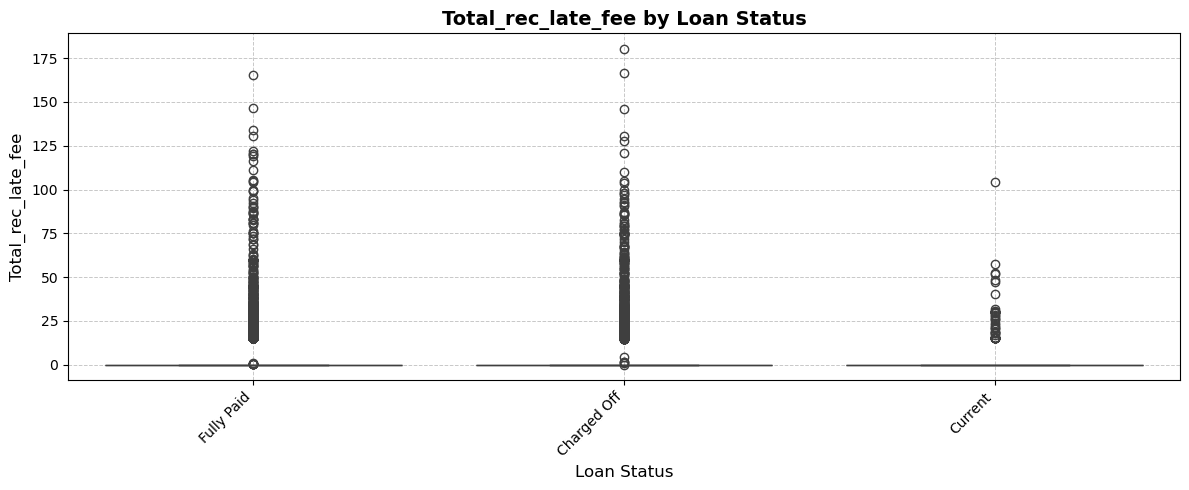

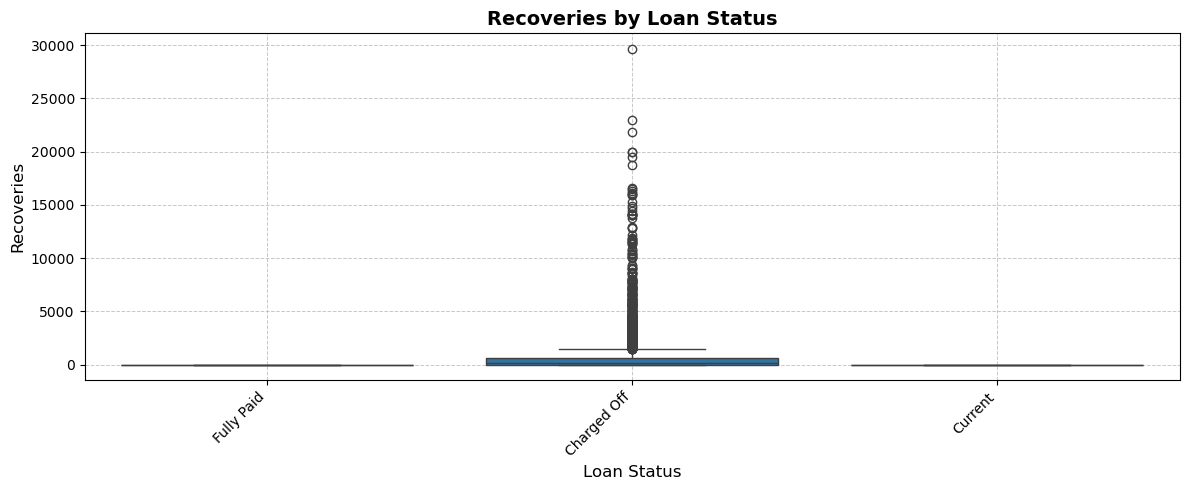

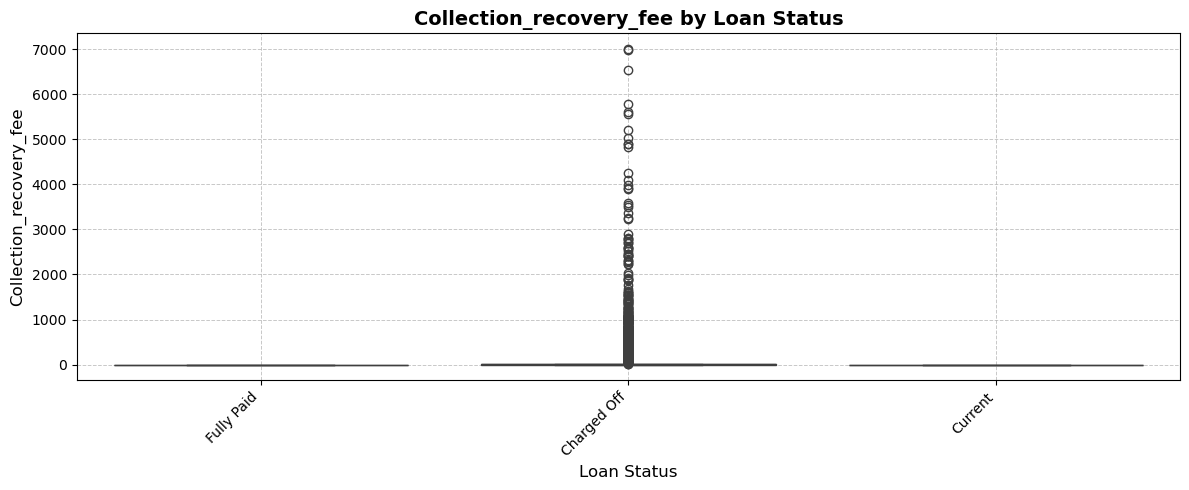

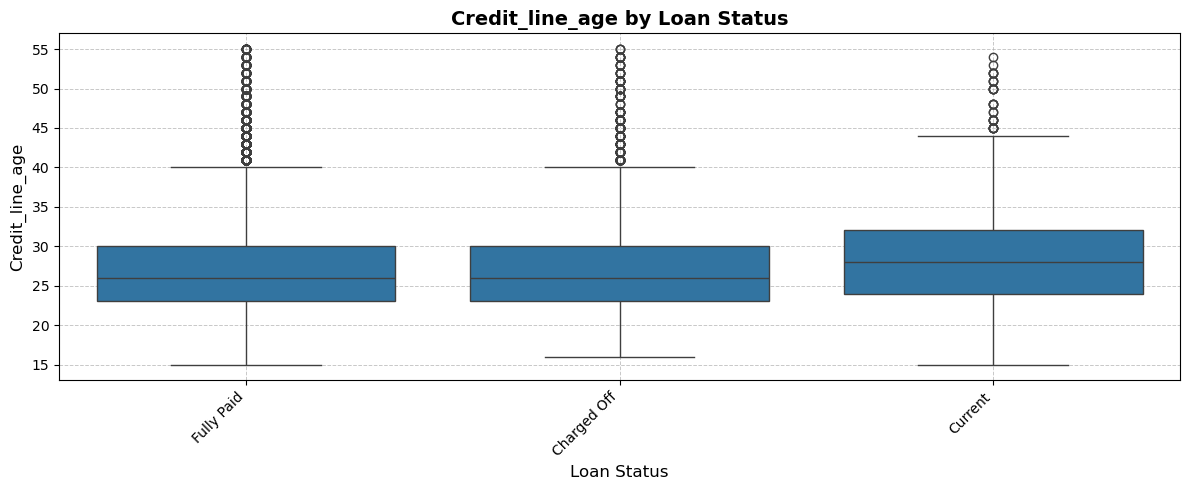

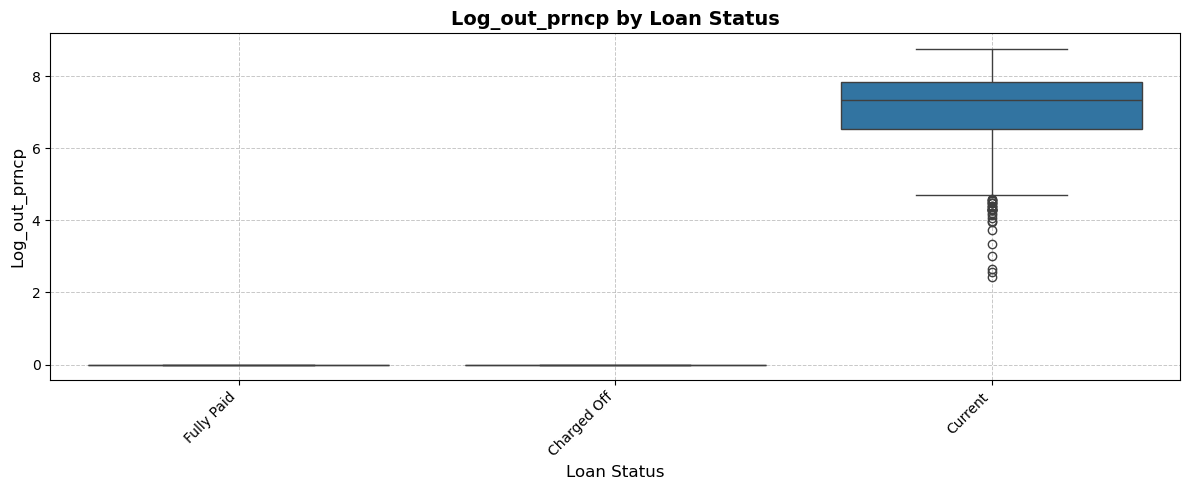

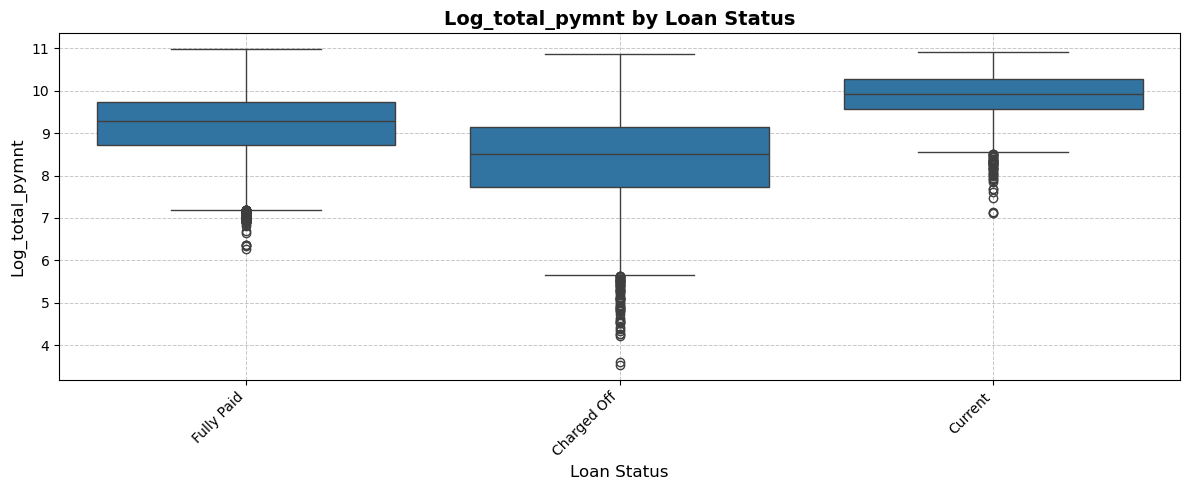

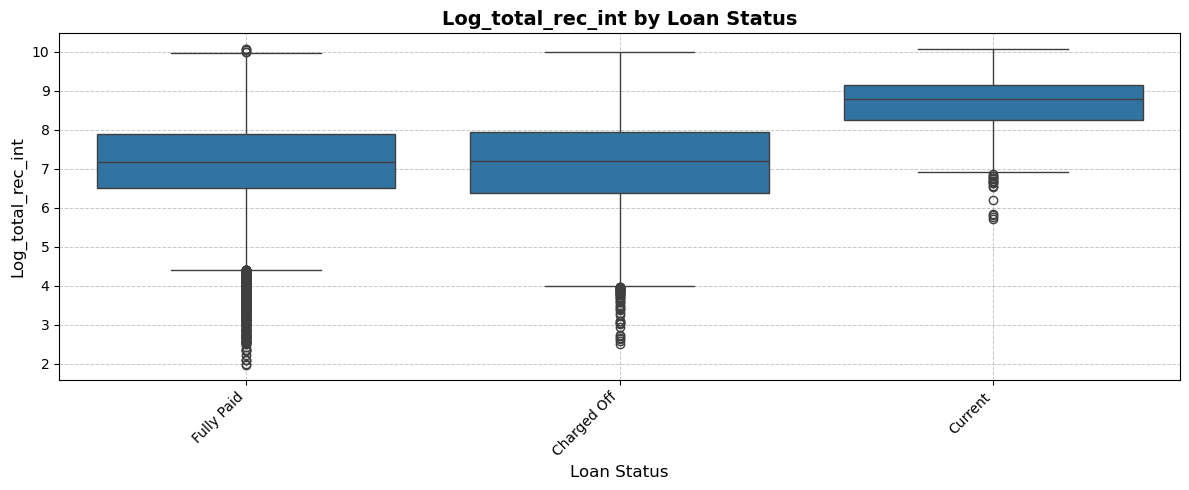

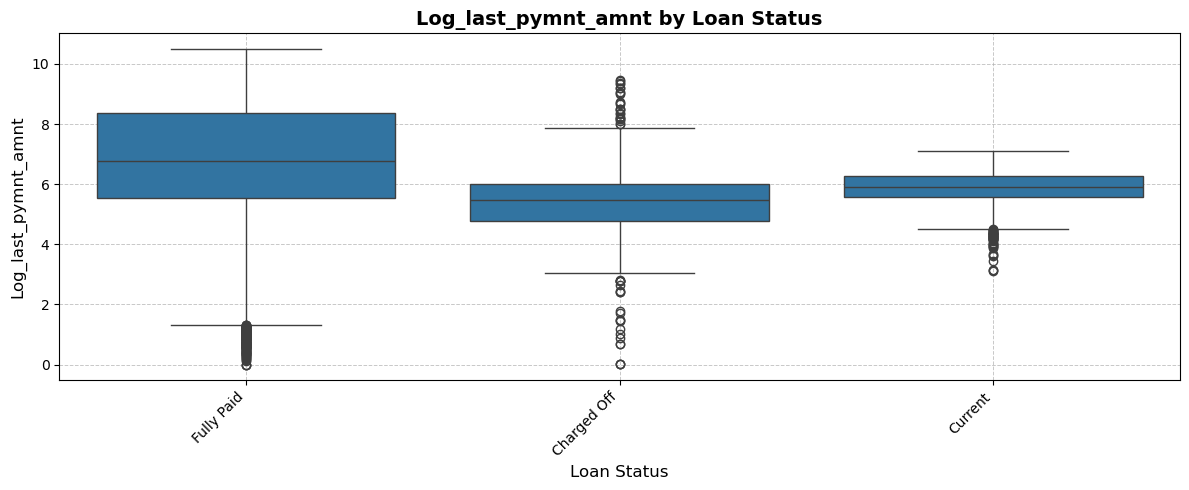

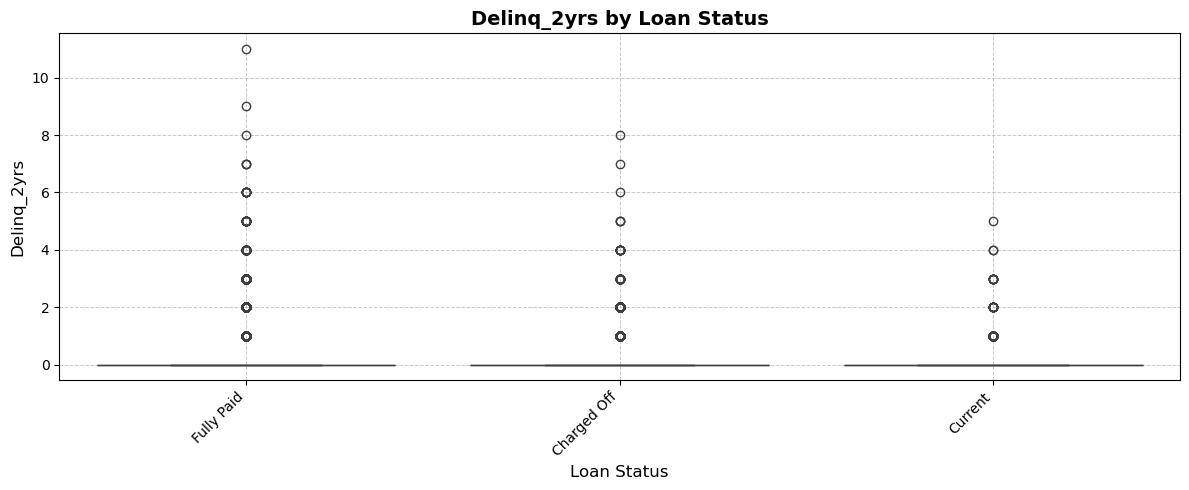

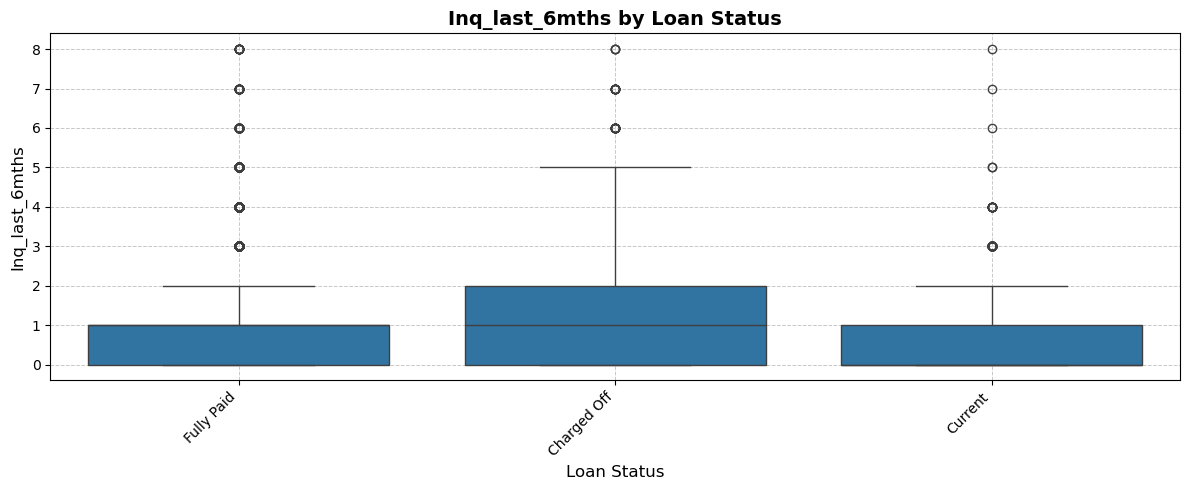

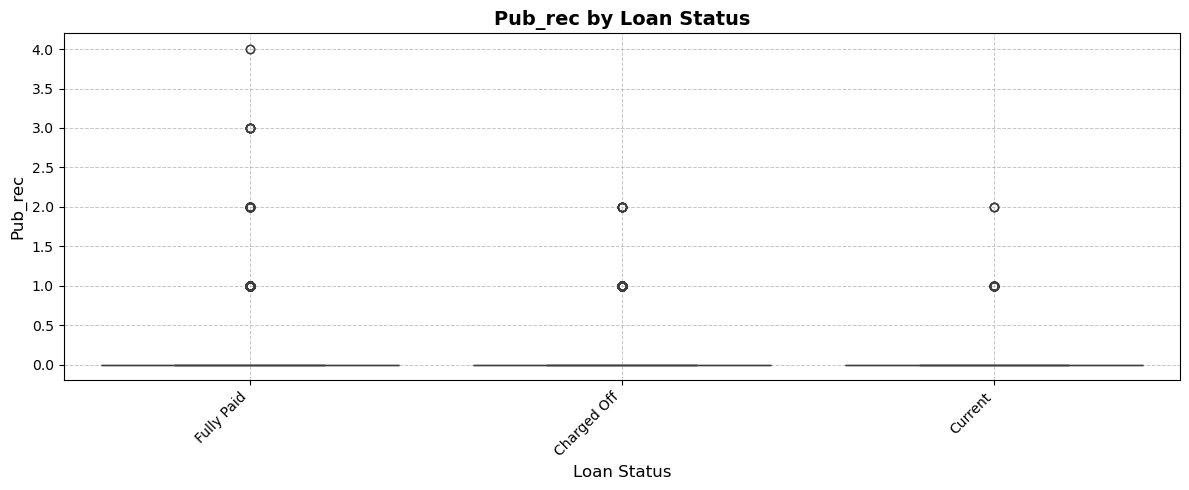

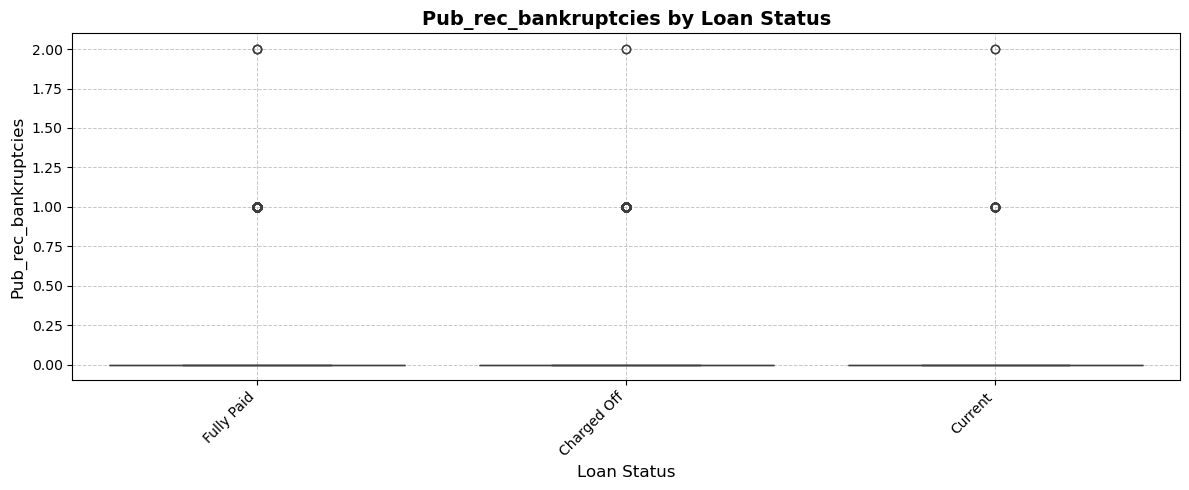

In [309]:
for col in num_cols:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='loan_status', y=loandf_cleaned[col], data=loandf_cleaned)
    # Set plot title and customize labels
    plt.title(f'{col.capitalize()} by Loan Status', fontsize=14, fontweight='bold')
    plt.xlabel('Loan Status', fontsize=12)
    plt.ylabel(col.capitalize(), fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add grid for better readability of plot
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

##### 1. loan_amnt, funded_amnt, funded_amnt_inv median and quratiles are slightly higher. The loans with current is more higher. This suggests there is a risk of defaults to increate.
##### 2.  Int_rate is also higher for defaults. Lokking at the box plot of current loans, seems the current loans are are at risk

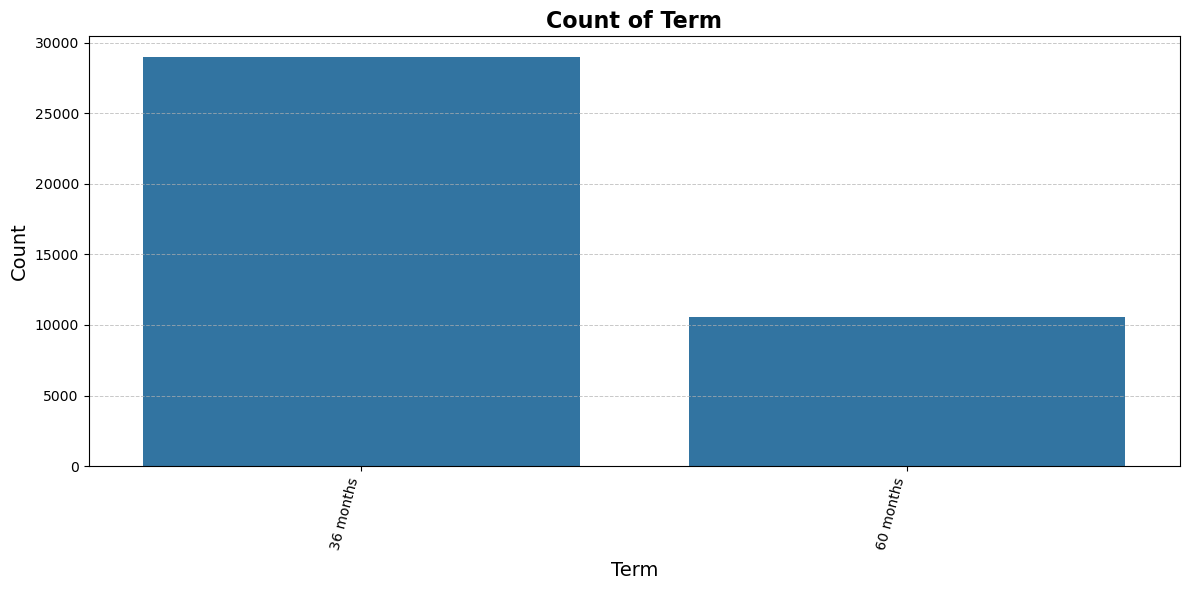

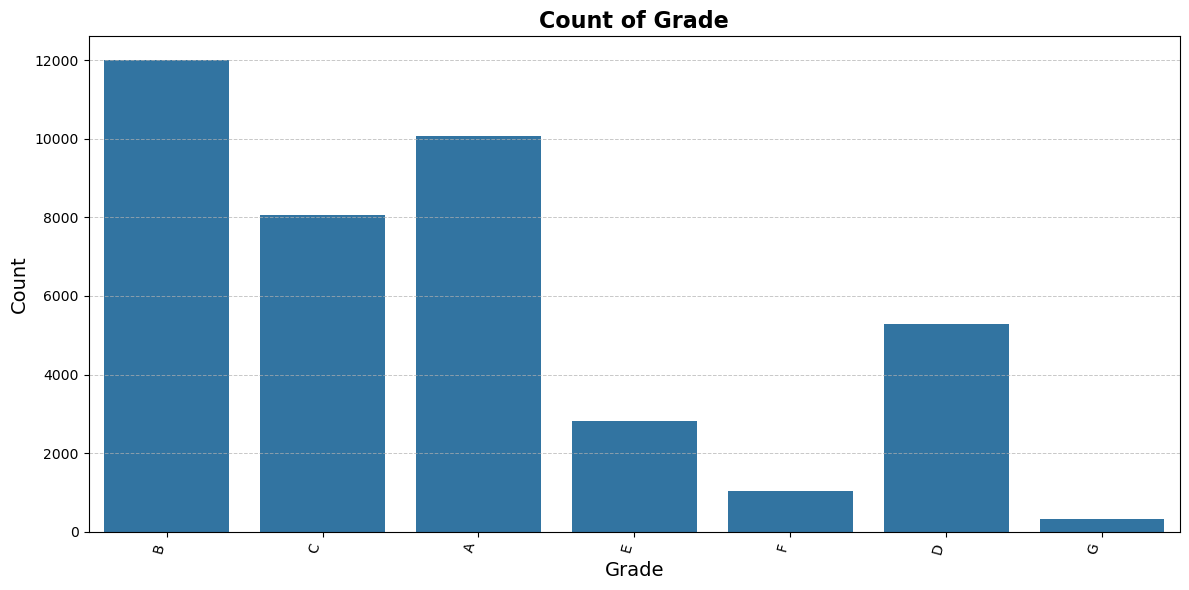

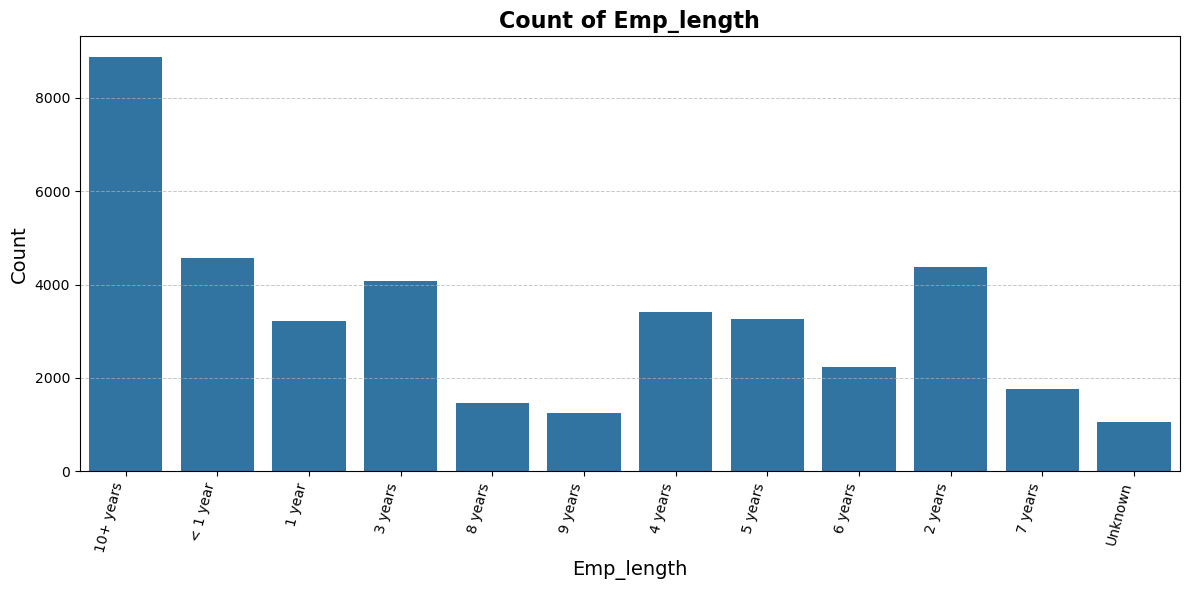

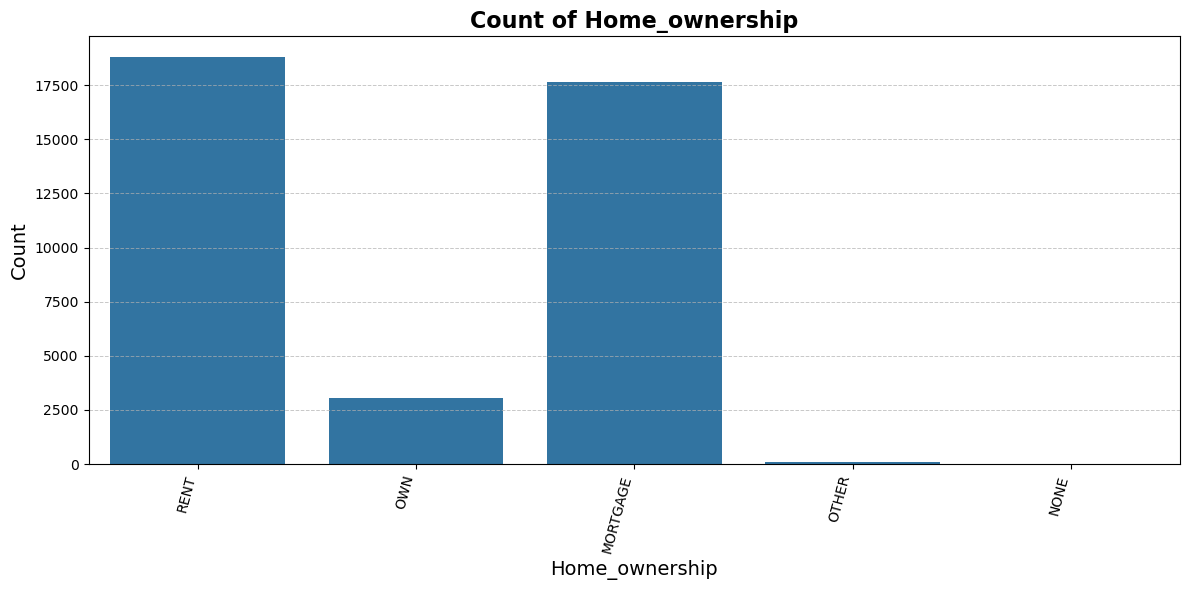

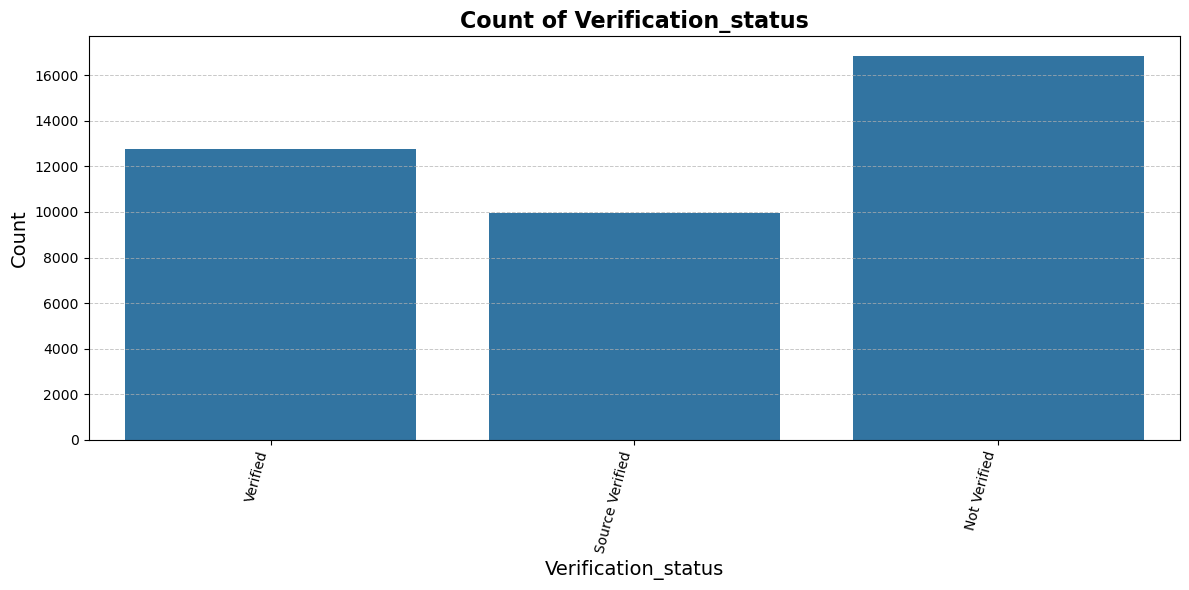

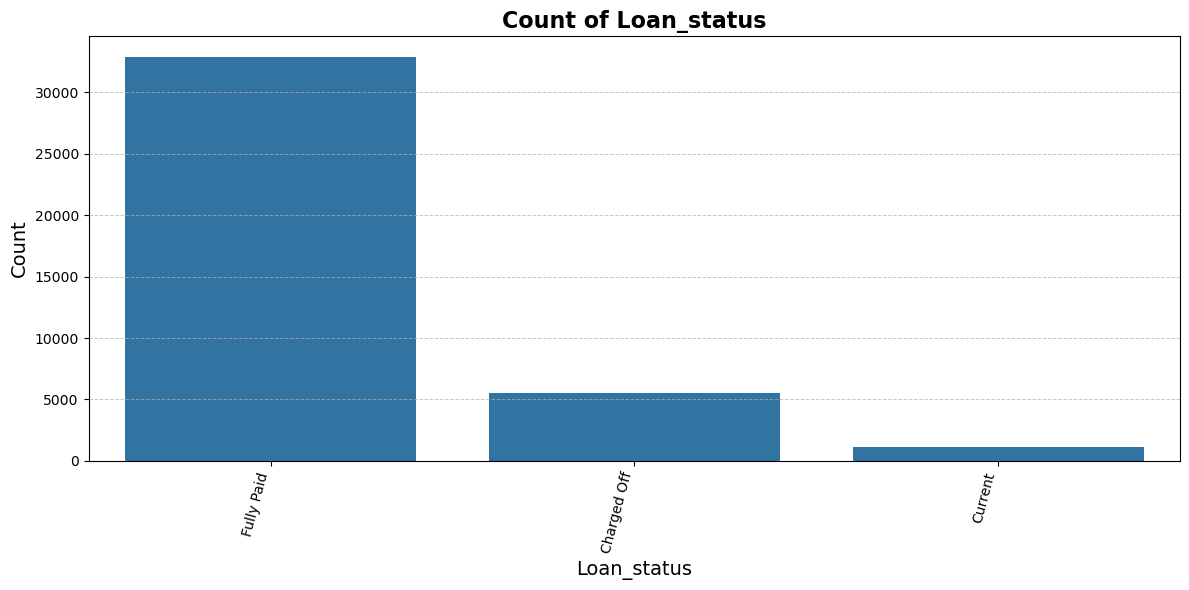

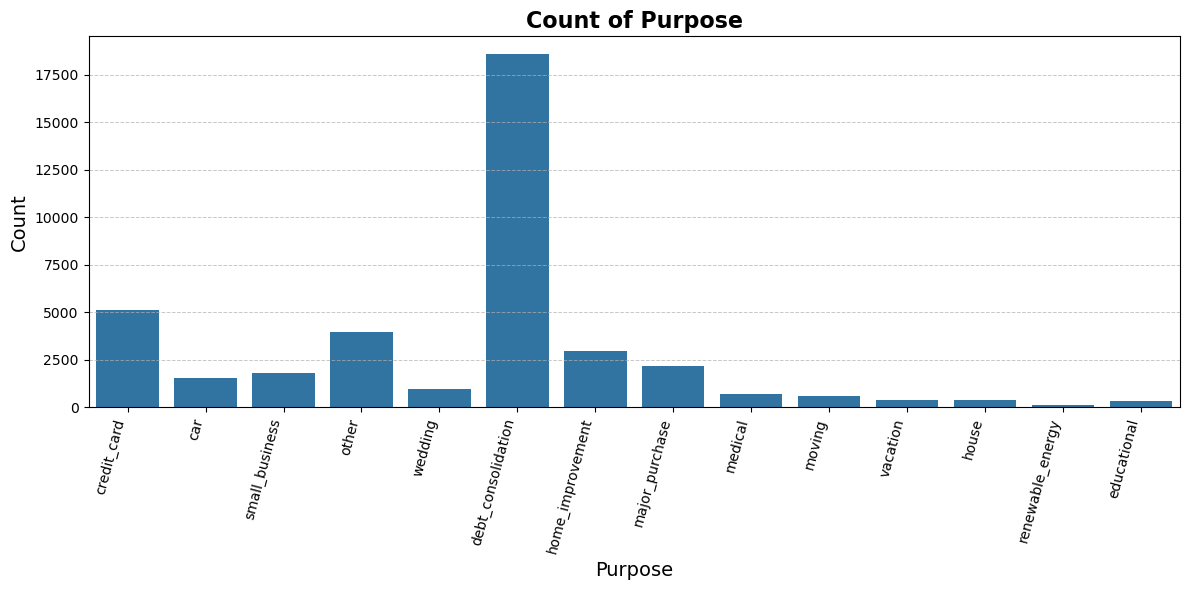

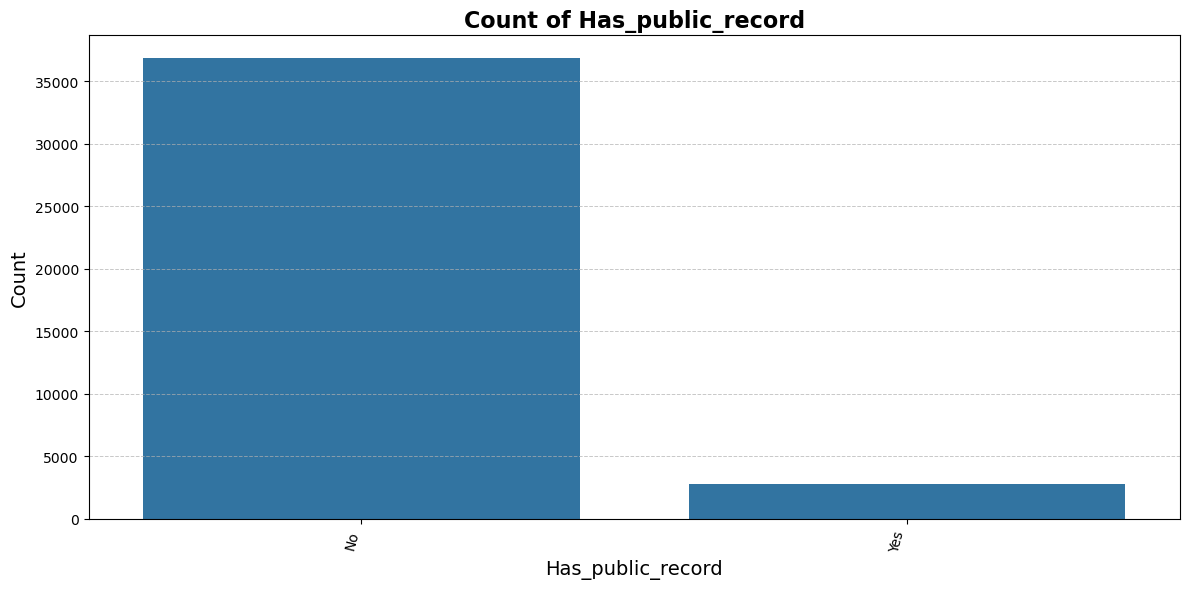

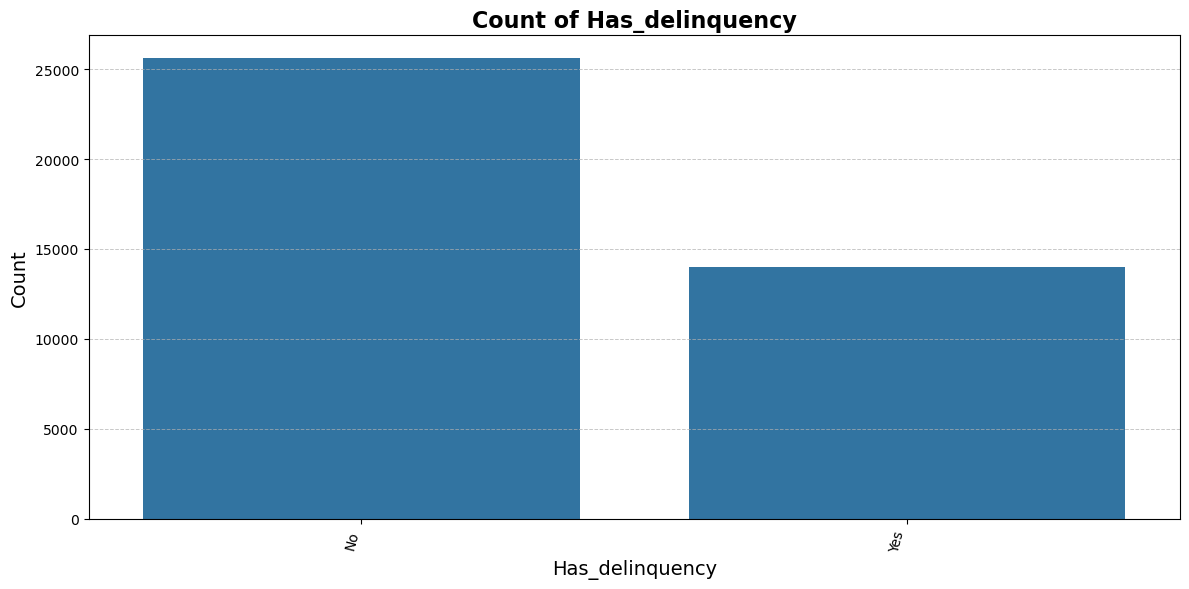

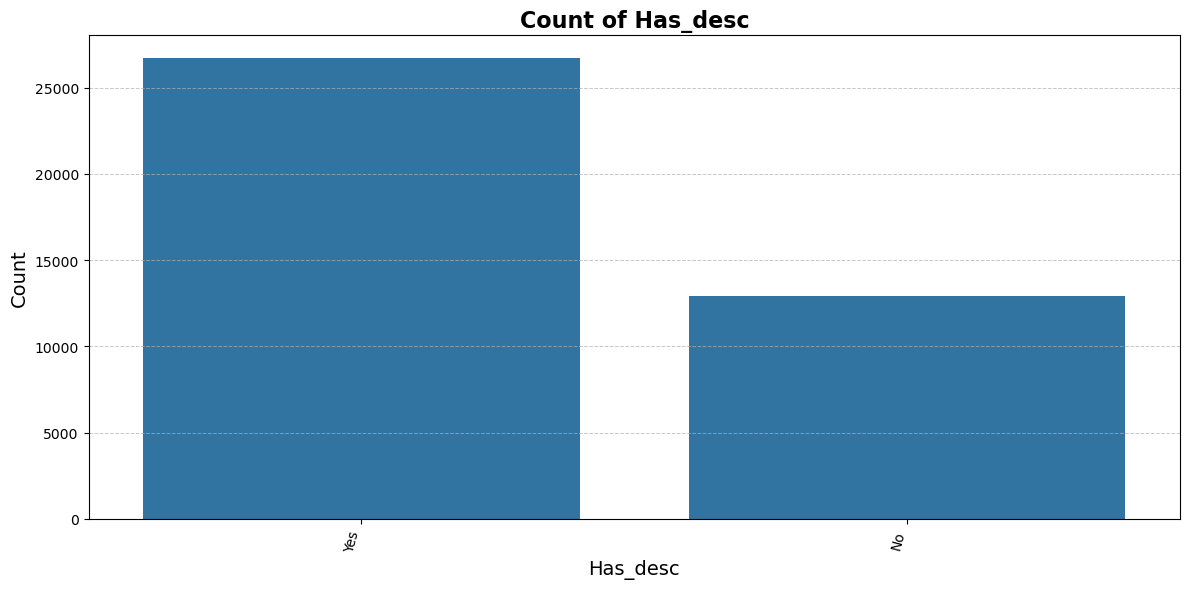

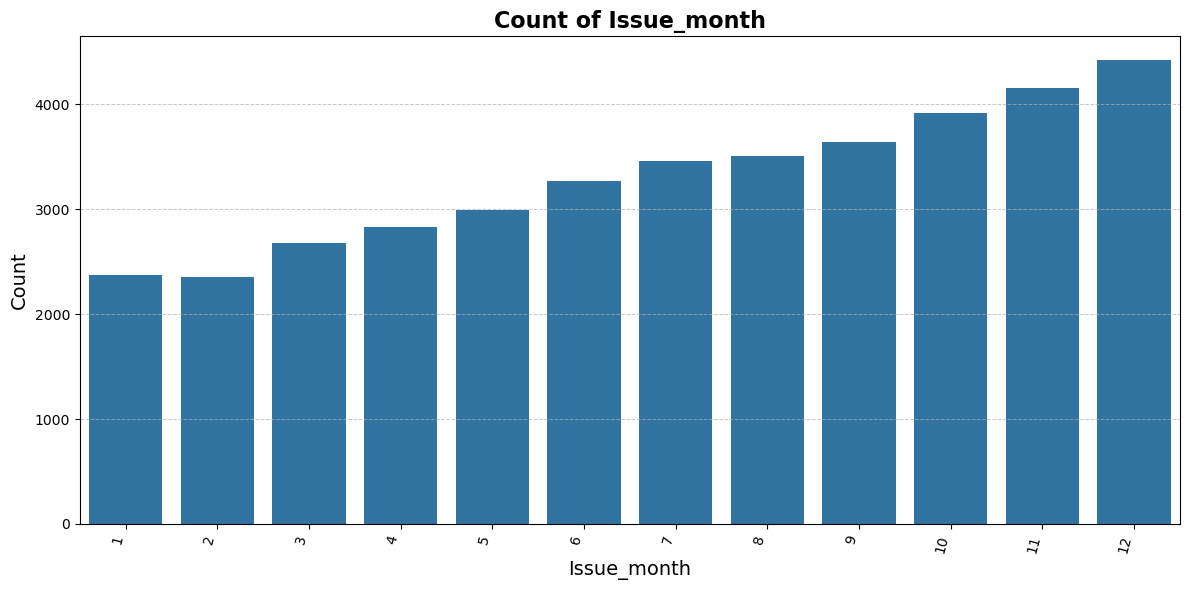

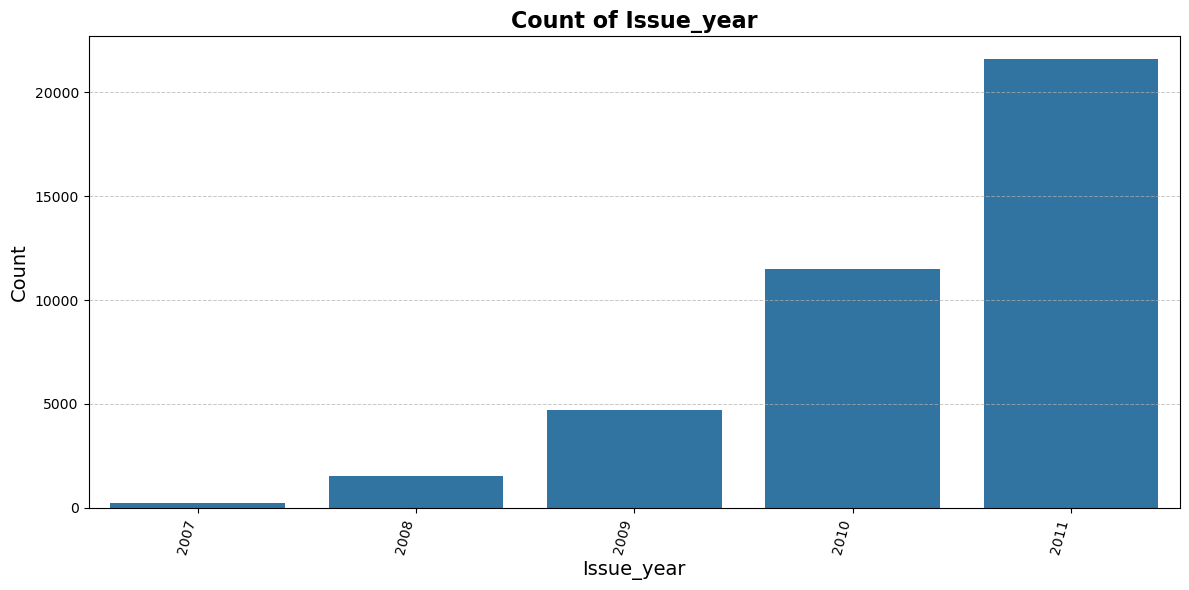

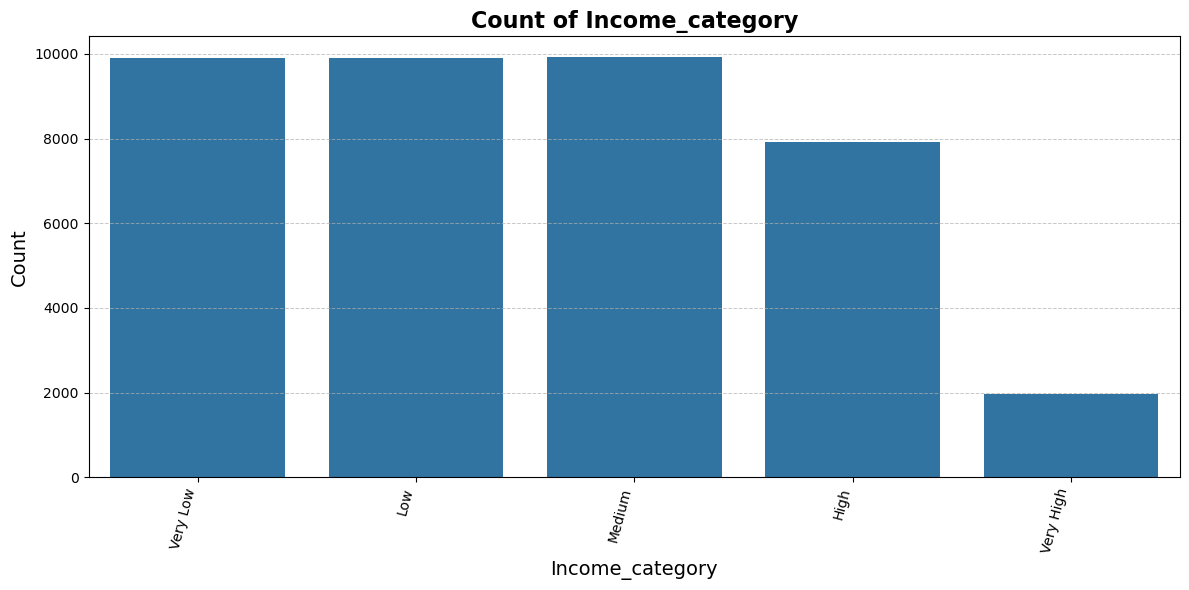

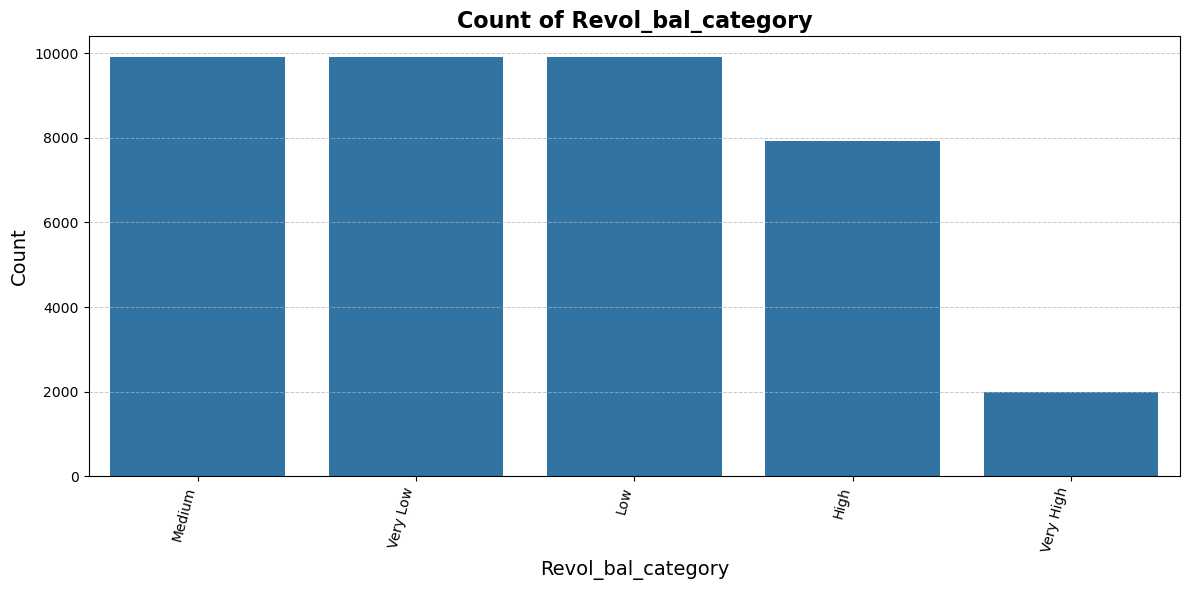

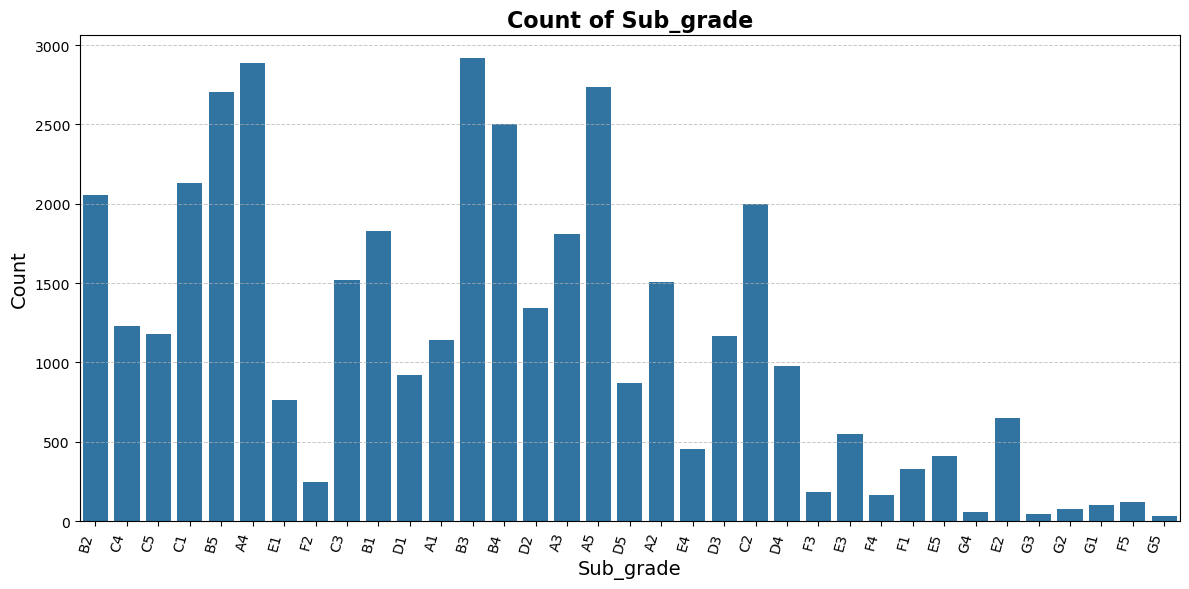

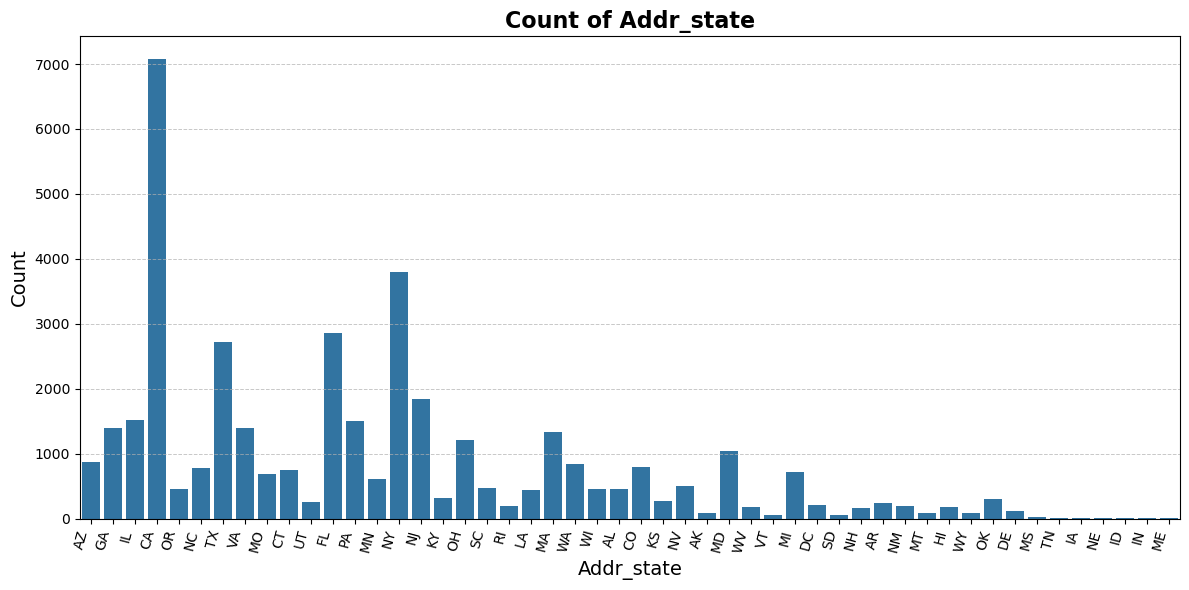

In [313]:
for col in cat_cols:
    plt.figure(figsize=(12, 6))  # Set figure size for each plot
    
    # Create a count plot for the current categorical column
    sns.countplot(x=loandf_cleaned[col])  # Optional: Add a color palette for better aesthetics
    
    # Set plot title and labels
    plt.title(f'Count of {col.capitalize()}', fontsize=16, fontweight='bold')
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=75, ha='right')  # 'ha' aligns labels to the right
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)  # Add grid lines only on y-axis
    
    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()

## Bivariate Analysis

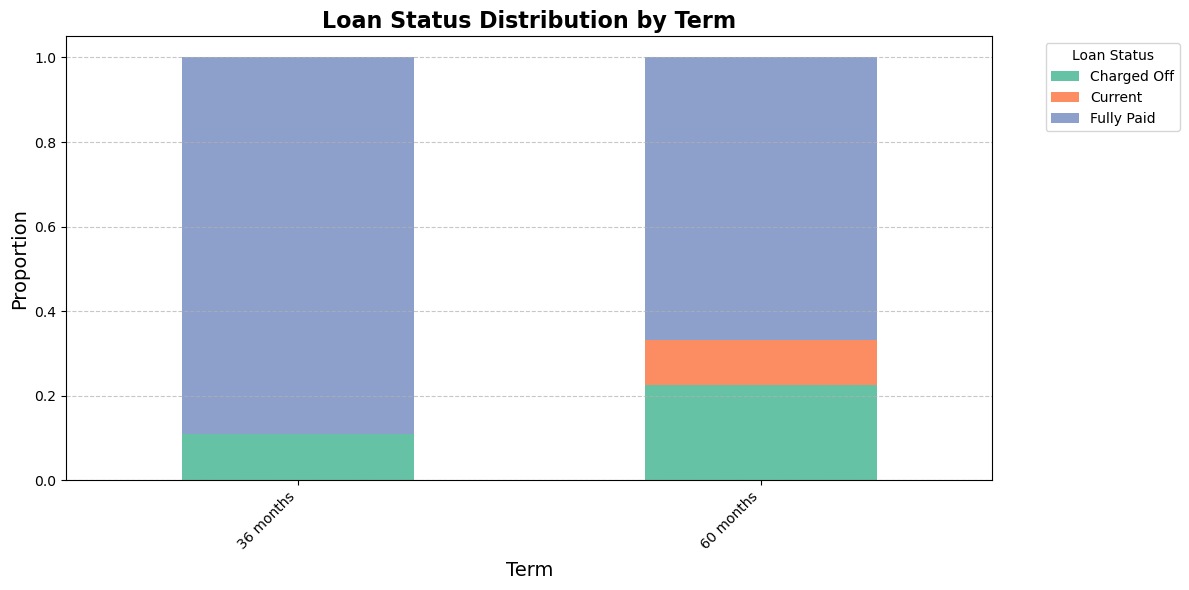

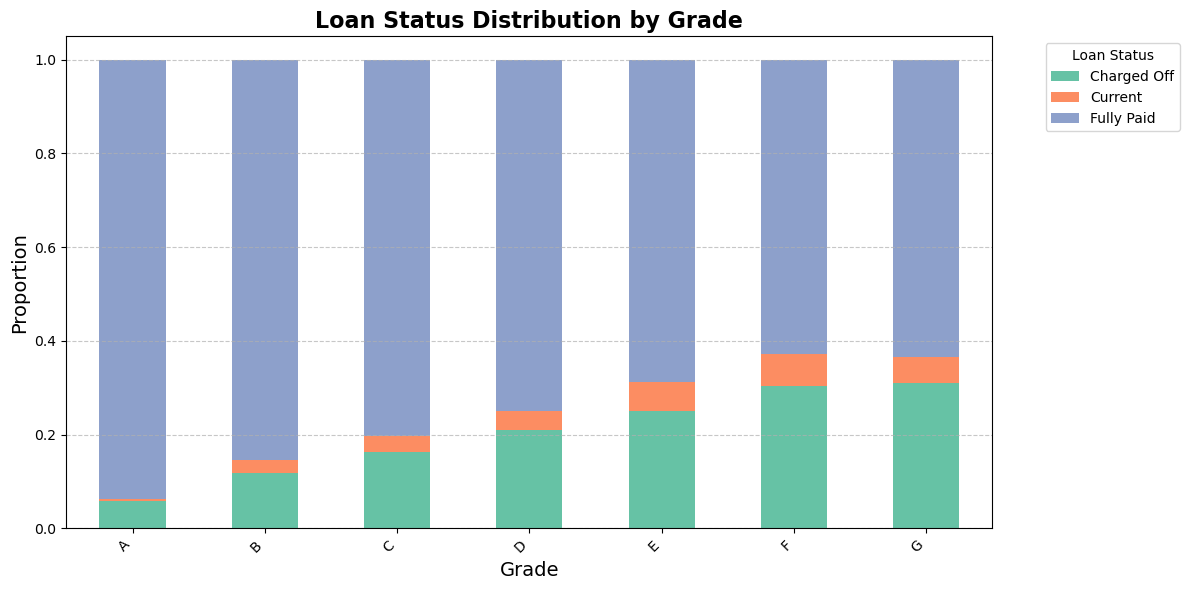

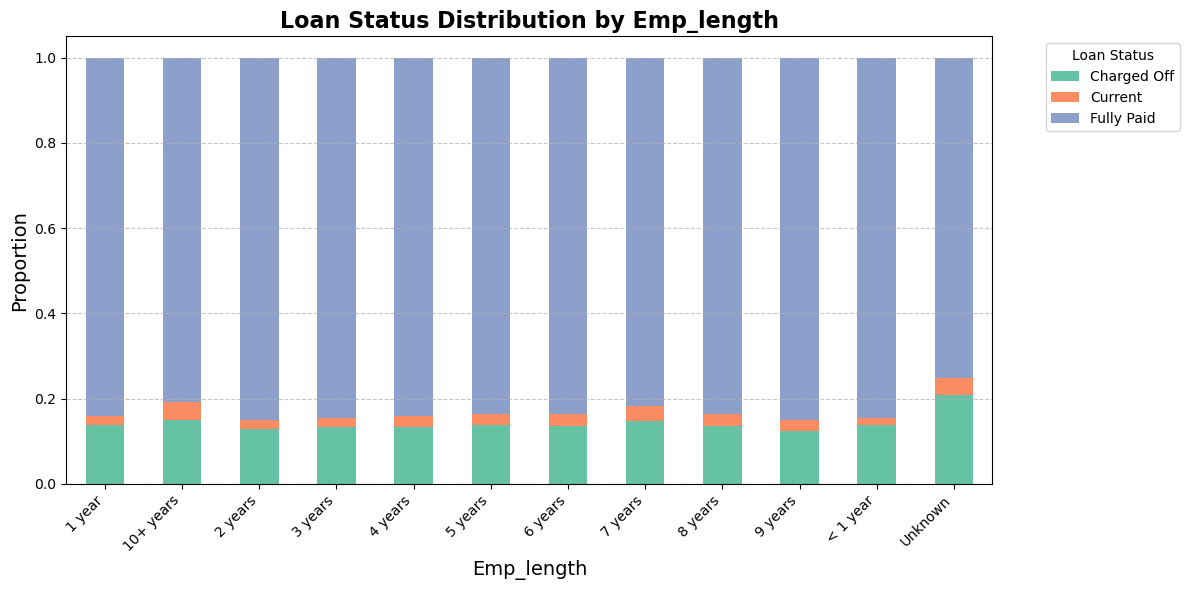

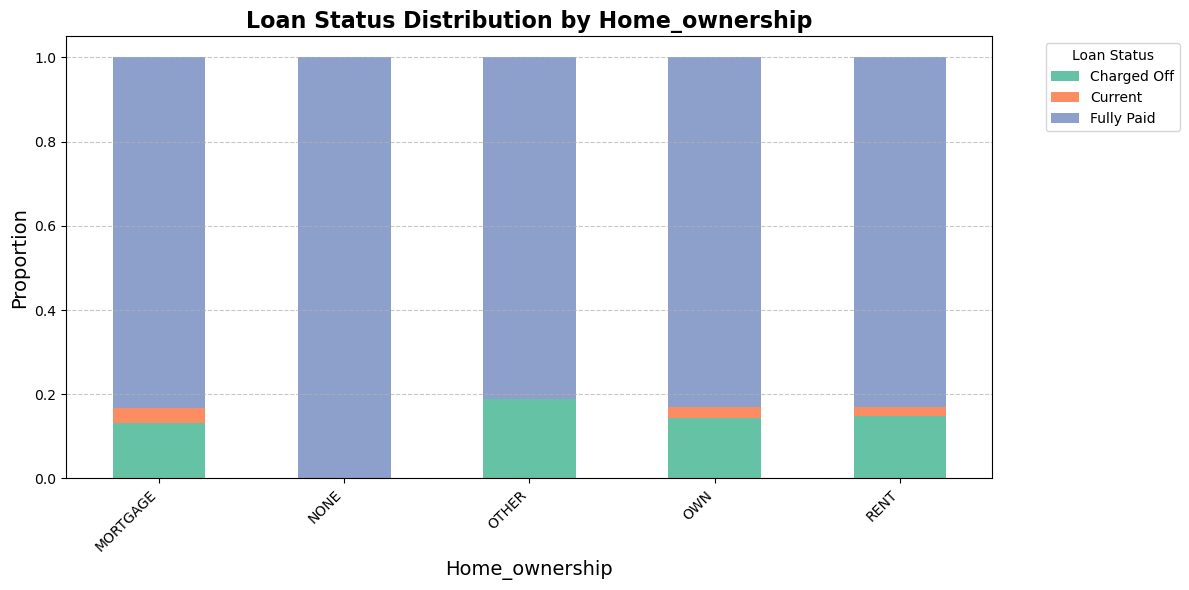

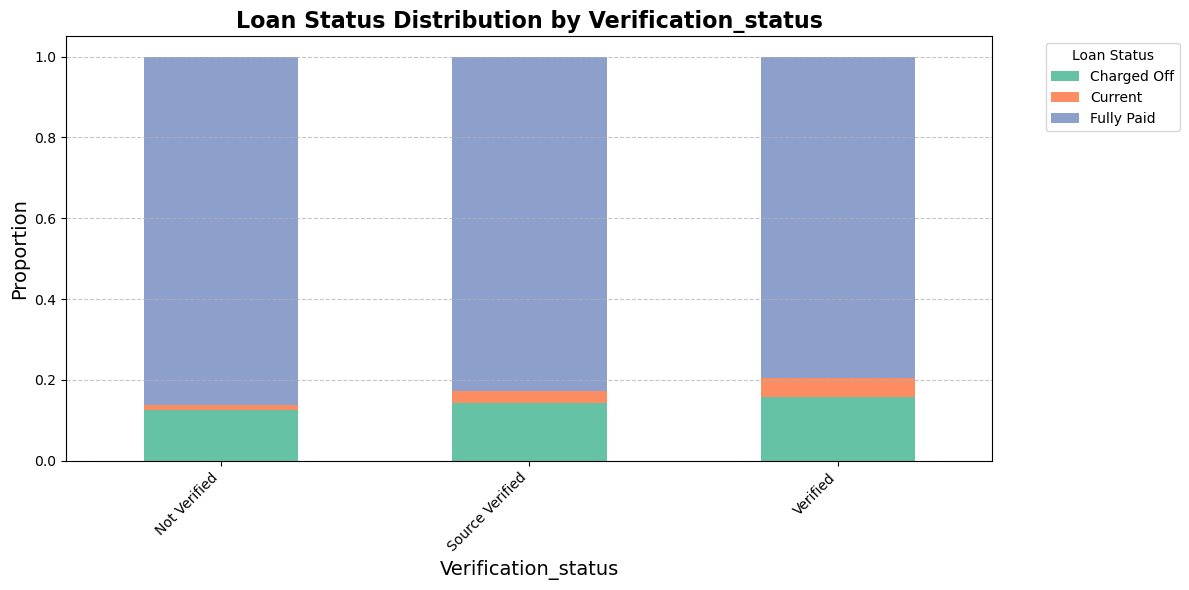

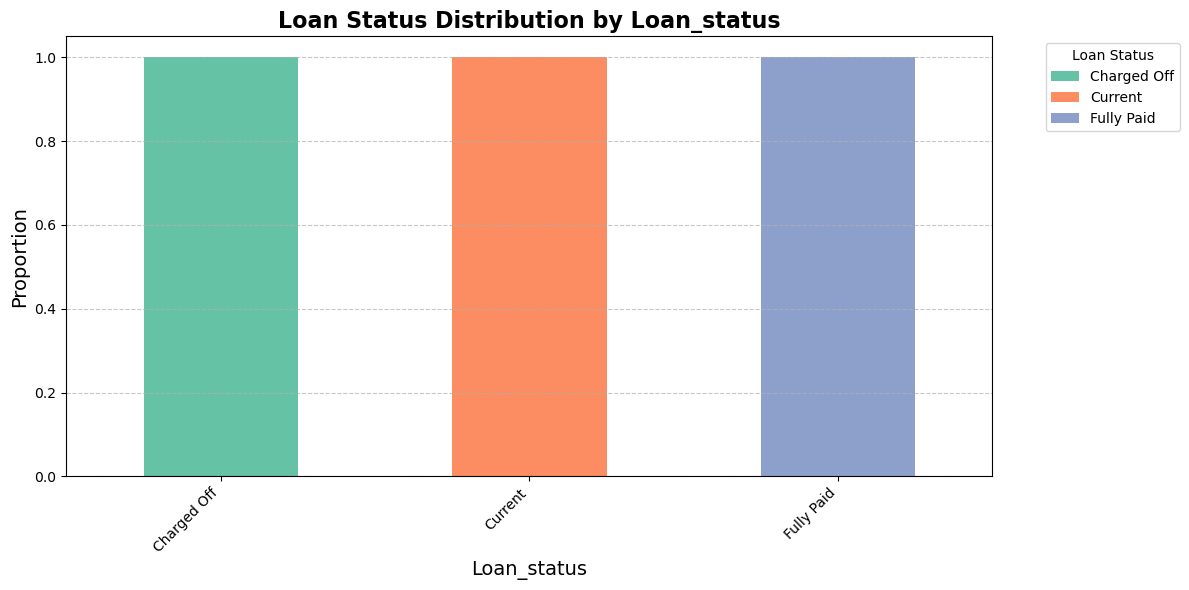

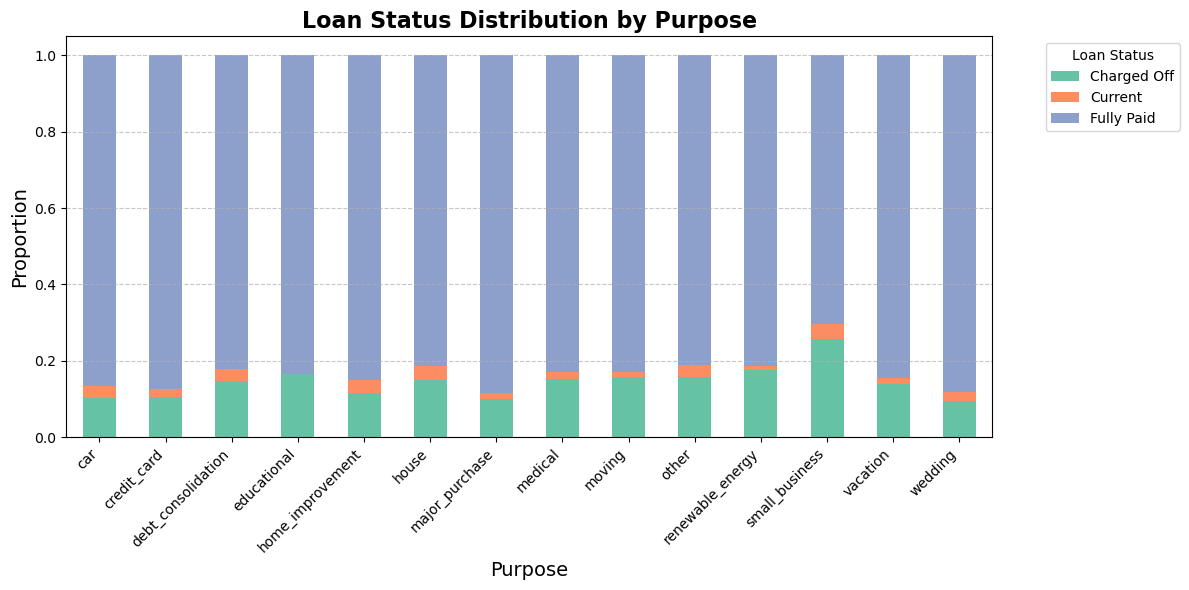

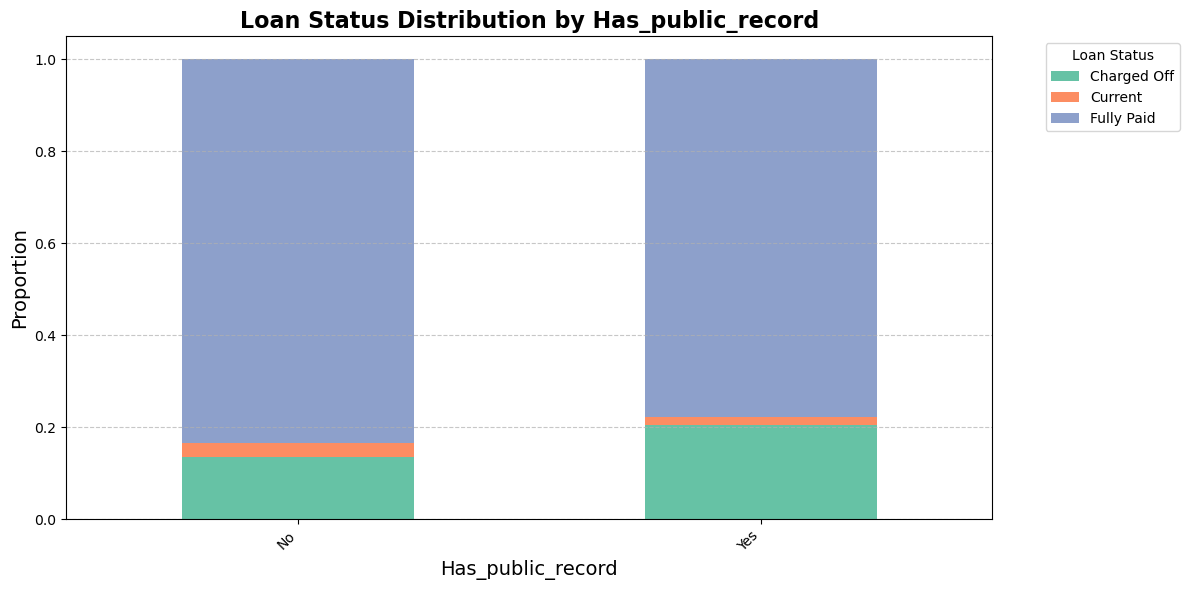

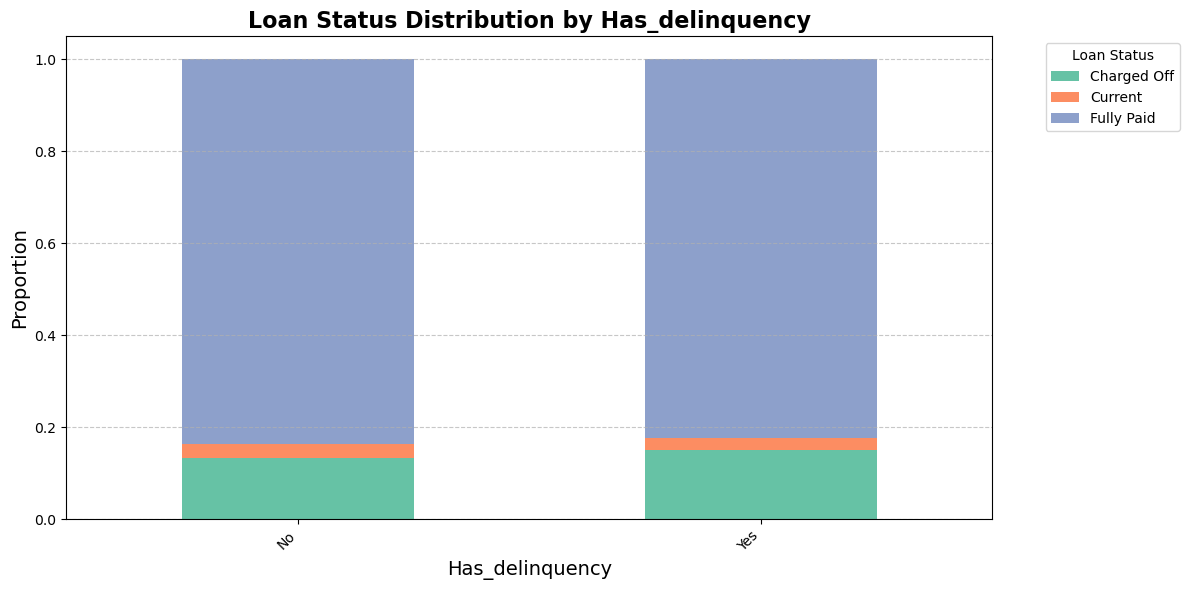

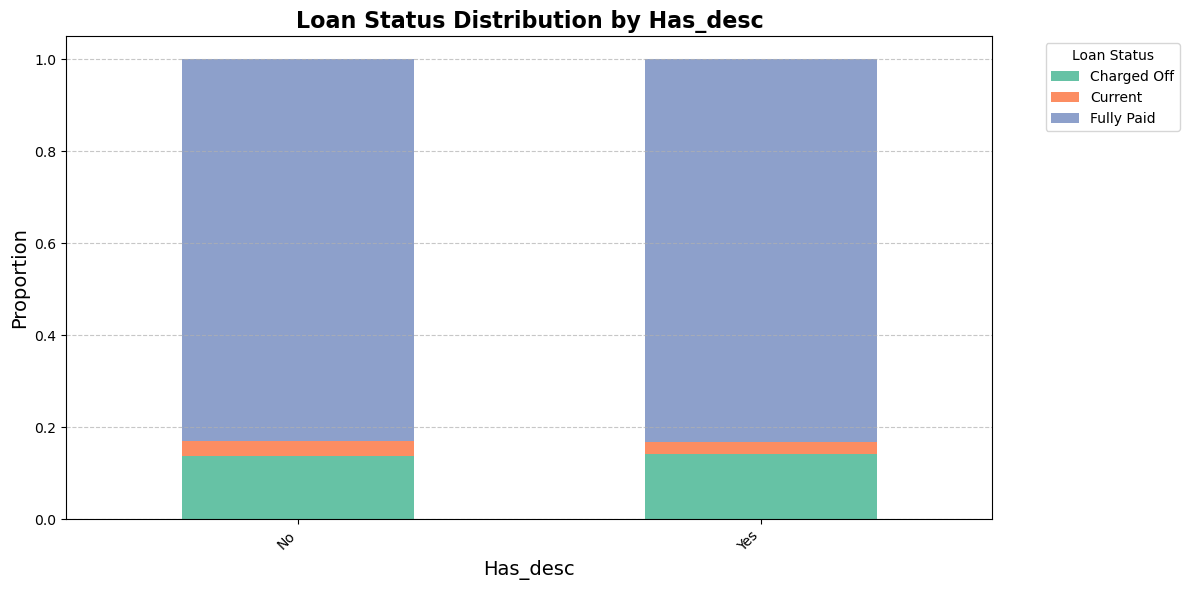

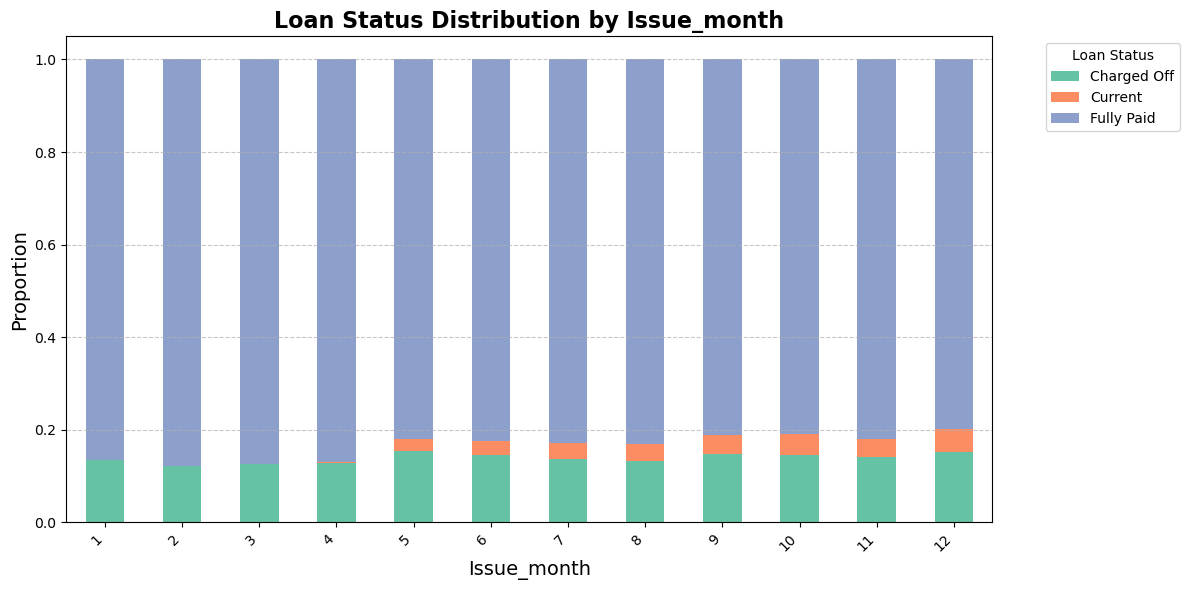

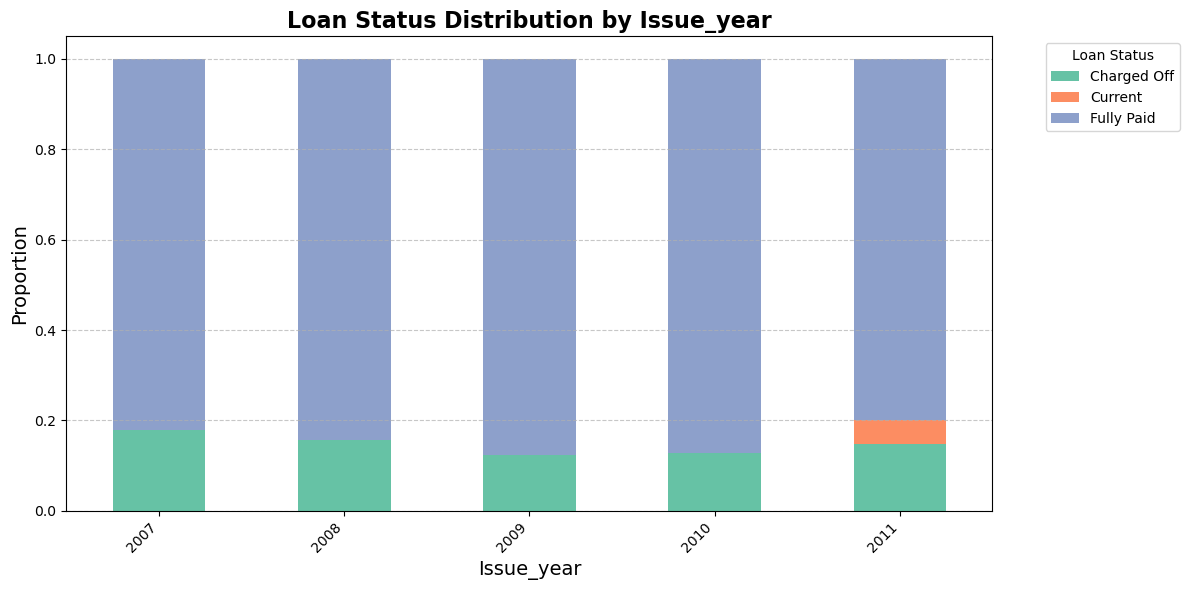

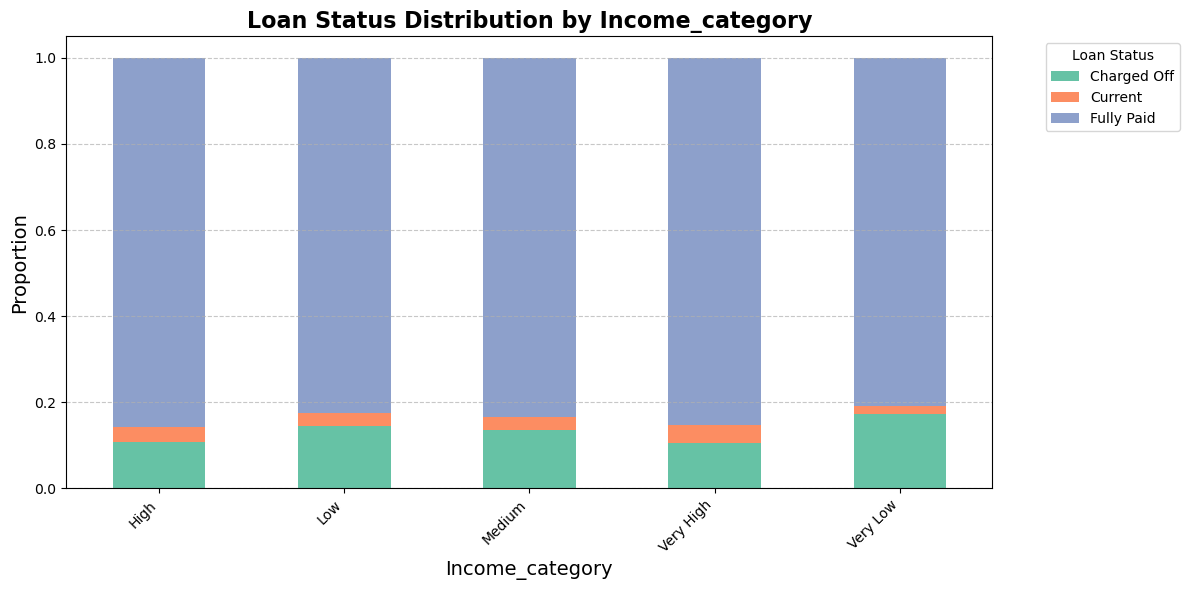

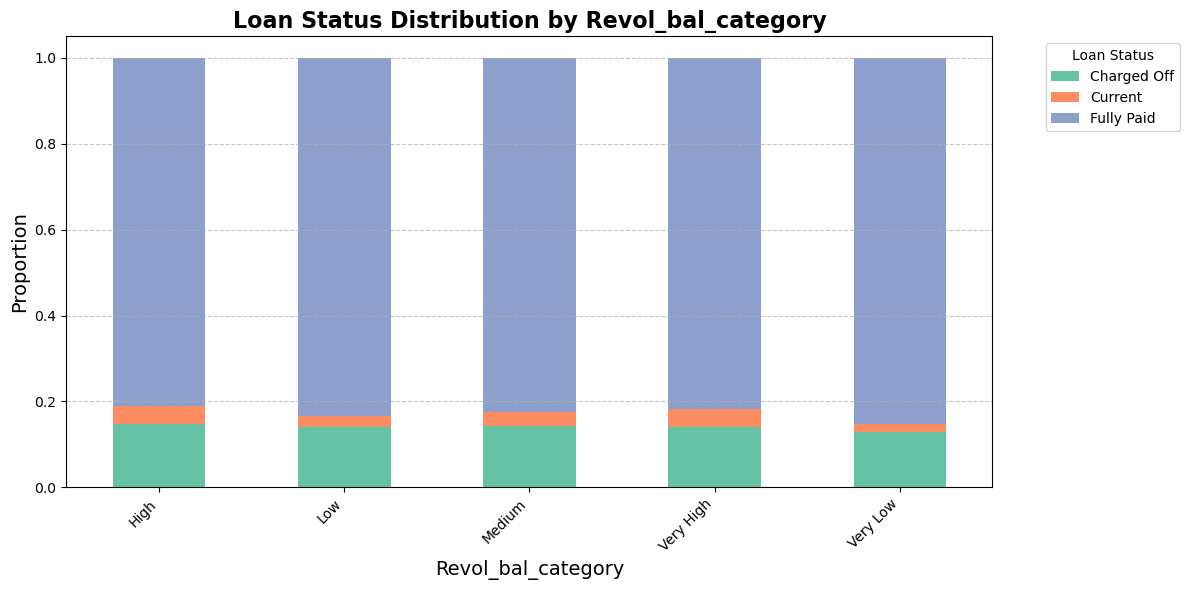

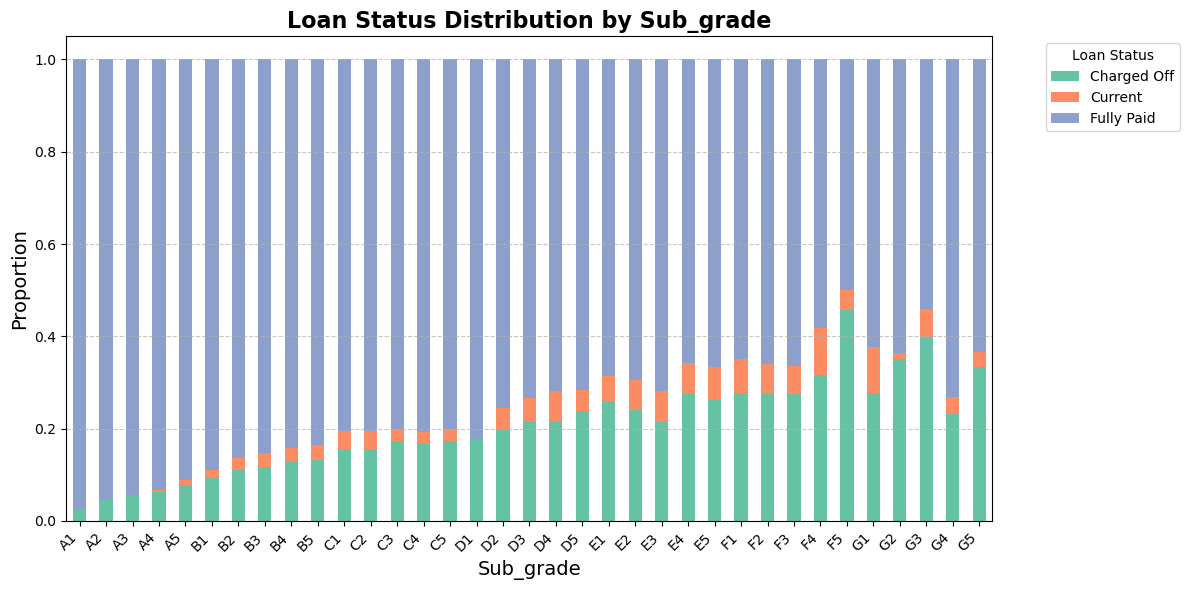

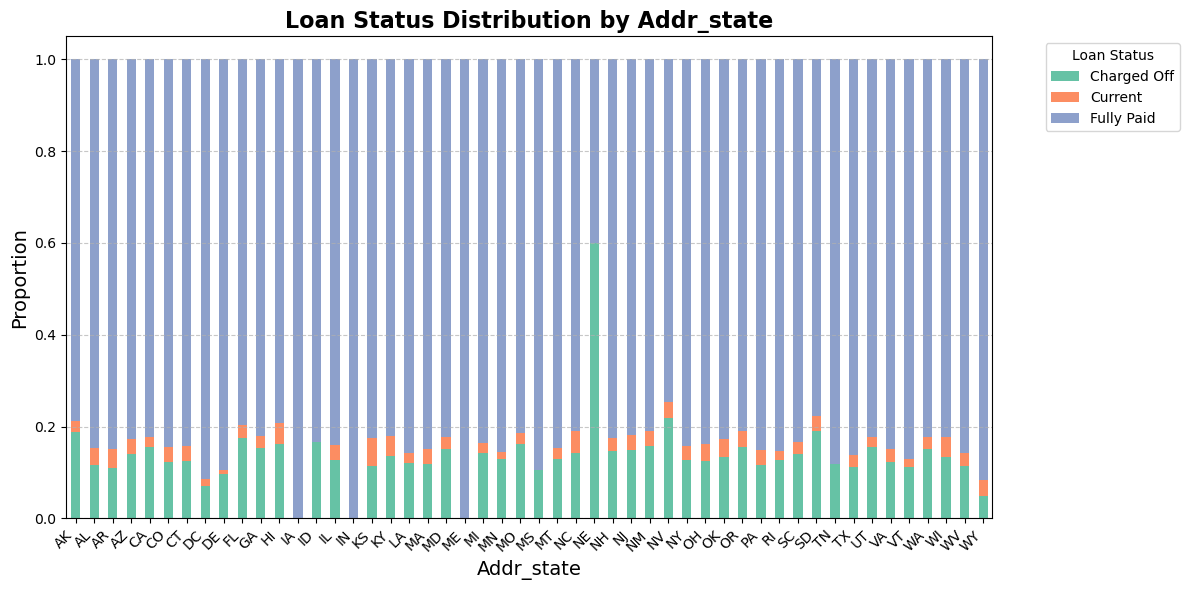

In [322]:
for col in cat_cols:
    # Create a crosstab for the current categorical column and loan status
    crosstab_data = pd.crosstab(loandf_cleaned[col], loandf_cleaned['loan_status'], normalize='index')
    
    # Plot the stacked bar plot
    ax = crosstab_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=sns.color_palette('Set2'))  # Optional: Use a color palette
    
    # Set plot title and labels
    plt.title(f'Loan Status Distribution by {col.capitalize()}', fontsize=16, fontweight='bold')
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    
    # Rotate x-axis labels for better readability if necessary
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
    
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines with dashed style

    # Add a legend
    plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    
    # Show the plot with a tight layout
    plt.tight_layout()
    plt.show()

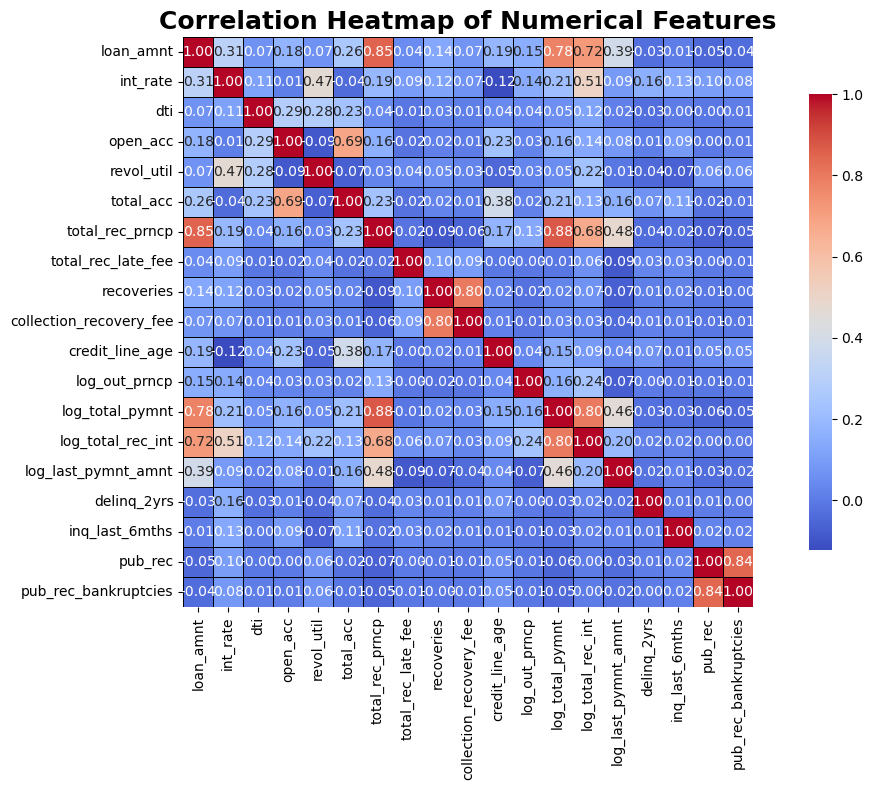

In [318]:
# Calculate the correlation matrix
corr = loandf_cleaned[num_cols].corr()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    corr,
    annot=True,                # Show correlation coefficients
    fmt=".2f",                 # Format the annotation text
    cmap='coolwarm',           # Color map for the heatmap
    square=True,               # Make squares
    linewidths=0.5,           # Width of lines separating the squares
    linecolor='black',         # Color of lines separating the squares
    cbar_kws={"shrink": .8}   # Shrink the color bar to fit the plot
)

# Set the title and adjust its size
plt.title('Correlation Heatmap of Numerical Features', fontsize=18, fontweight='bold')

# Show the plot
plt.tight_layout()  # Adjust layout to fit the title and labels
plt.show()